Nota: Este trabalho tem por base uma base de dados fictícia, apenas utilizada para demonstrar conheimento técnico e interprettivo.

## Trabalho HP Bank

Este trabalho aborda o desafio crescente das instituições financeiras em antecipar situações de incumprimento num contexto de aumento do crédito ao consumo e de maior complexidade dos produtos bancários. <br> Prever quais clientes poderão falhar o pagamento deixou de ser uma vantagem competitiva para se tornar uma necessidade operacional. A volatilidade económica e a exposição ao risco exigem sistemas analíticos capazes de transformar dados financeiros em indicadores fiáveis de alerta precoce.

Com este enquadramento, o presente estudo tem como objetivo desenvolver um sistema preditivo de risco de crédito baseado em Machine Learning, simulando todas as etapas de um processo real de modelação no setor bancário. <br> O trabalho inclui a análise exploratória do dataset, a identificação de padrões associados ao incumprimento, a preparação e transformação dos dados, o treino e comparação de vários algoritmos e a avaliação do impacto económico das previsões. Adicionalmente, é otimizado o threshold de decisão, não apenas com base em métricas de desempenho, mas de forma a minimizar o prejuízo financeiro para o banco. No final, pretende-se demonstrar competência técnica e capacidade de interpretar resultados no contexto real do negócio, contribuindo para uma gestão de risco mais informada e eficaz.

In [2]:
#importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


In [3]:
# Se o separador for",", deve ser alterado com "sep"
df=pd.read_csv(r'C:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Trabalho Final\Tenya_Dataset.csv', sep=';')

In [4]:
# Numero de linhas, colunas e tipos de dados
# Podiamos usar também df.shape para saber o numero de linhas e colunas
# E ainda df.dtypes para saber os tipos de dados
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID_Cliente                  30000 non-null  int64  
 1   Limite_Credito              30000 non-null  int64  
 2   Genero                      29997 non-null  object 
 3   Escolaridade                30000 non-null  int64  
 4   Estado_Civil                30000 non-null  int64  
 5   Idade                       29995 non-null  float64
 6   Atraso_Pagamento_Setembro   30000 non-null  int64  
 7   Atraso_Pagamento_Agosto     30000 non-null  int64  
 8   Atraso_Pagamento_Julho      30000 non-null  int64  
 9   Atraso_Pagamento_Junho      30000 non-null  int64  
 10  Atraso_Pagamento_Maio       30000 non-null  int64  
 11  Atraso_Pagamento_Abril      30000 non-null  int64  
 12  Fatura_Setembro             30000 non-null  int64  
 13  Fatura_Agosto               300

O dataset utilizado contém 30.000 registos de clientes, organizados em 25 variáveis que abrangem informação demográfica, limites de crédito, histórico de faturas e pagamentos, e indicadores de atraso. A maioria das variáveis é de tipo numérico inteiro, exceto Idade, registada como float, e Género, categórica.

Os dados apresentam uma qualidade global elevada, com quase todas as variáveis completas; apenas Género (3 valores em falta) e Idade (5 valores em falta) têm lacunas residuais. Entre as principais categorias de informação estão:<br>
Características do cliente: ID, género, idade, escolaridade e estado civil;<br>
Informação financeira: limite de crédito e valores das faturas mensais;<br>
Histórico de pagamentos: montantes pagos e níveis de atraso de Abril a Setembro;<br>
Variável-alvo: Incumprimento_Mes_Seguinte, indicando se o cliente entrou ou não em incumprimento.<br>

Este conjunto de variáveis permite uma análise abrangente do comportamento financeiro dos clientes e constitui uma base sólida para o desenvolvimento de modelos preditivos de risco de incumprimento.

In [5]:
# 5 primeiras linhas do dataset
df.head()

,ID_Cliente,Limite_Credito,Genero,Escolaridade,Estado_Civil,Idade,Atraso_Pagamento_Setembro,Atraso_Pagamento_Agosto,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,...,Fatura_Junho,Fatura_Maio,Fatura_Abril,Pagamento_Setembro,Pagamento_Agosto,Pagamento_Julho,Pagamento_Junho,Pagamento_Maio,Pagamento_Abril,Incumprimento_Mes_Seguinte
0,1,20000,Feminino,2,1,24.0,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,Feminino,2,2,26.0,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,Feminino,2,2,34.0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,Feminino,2,1,37.0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,Masculino,2,1,57.0,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**ID**: Identificação única de cada cliente

**Limite_Credito**: Montante total de crédito atribuído ao cliente (em dólares NT), incluindo crédito individual e crédito adicional/familiar (suplementar).

**Genero** - Género Masculino e Feminino

**Escolaridade**: (1=Ensino Básico, 2=Ensino Universitário, 3=Ensino Secundário, 4=others, 5=desconhecido, 6=desconhecido)

**Estado Civil**: (1=Casado, 2=Solteiro, 3=others)

**Idade**: Idade em anos

**Atraso_Pagamento_Setembro**: (-1=não há atraso, 1=atraso no pagamento por 1 mês, 2=atraso por 2 meses, ... 8=atraso por 8 meses, 9=atraso por 9 meses ou mais)

**Atraso_Pagamento_Agosto**: Estado do pagamento em agosto (mesma escala acima).

**Atraso_Pagamento_Julho**: Estado do pagamento em julho (mesma escala acima).

**Atraso_Pagamento_Junho**: Estado do pagamento em junho (mesma escala acima).

**Atraso_Pagamento_Maio**: Estado do pagamento em maio (mesma escala acima).

**Atraso_Pagamento_Abril**: Estado do pagamento em abril (mesma escala acima).

**Fatura_Setembro**: Valor da fatura emitida em setembro de 2005 (em dólares NT).

**Fatura_Agosto**: Valor da fatura emitida em agosto de 2005 (em dólares NT).

**Fatura_Julho**: Valor da fatura emitida em julho de 2005 (em dólares NT).

**Fatura_Junho**: Valor da fatura emitida em junho de 2005 (em dólares NT).

**Fatura_Maio**: Valor da fatura emitida em maio de 2005 (em dólares NT).

**Fatura_Abril**: Valor da fatura emitida em abril de 2005 (em dólares NT).

**Pagamento_Setembro**: Valor pago pelo cliente em setembro de 2005 (em dólares NT).

**Pagamento_Agosto**: Valor pago pelo cliente em agosto de 2005 (em dólares NT).

**Pagamento_Julho**: Valor pago pelo cliente em julho de 2005 (em dólares NT).

**Pagamento_Junho**: Valor pago pelo cliente em junho de 2005 (em dólares NT).

**Pagamento_Maio**: Valor pago pelo cliente em maio de 2005 (em dólares NT).

**Pagamento_Abril**: Valor pago pelo cliente em abril de 2005 (em dólares NT).

**Incumprimento_Mes_Seguinte**: 1 = cliente entrou em incumprimento;
0 = cliente não entrou em incumprimento

In [6]:
# Percentual de clientes que incumpriram no mês seguinte
target_col = "Incumprimento_Mes_Seguinte"
taxa_incumprimento = df[target_col].mean() * 100
print(f"Taxa de incumprimento: {taxa_incumprimento:.2f}%")

Taxa de incumprimento: 22.12%


A taxa de incumprimento é de 22,12%, ou seja 22,12% dos clientes entraram em incumprimento no mês seguinte.<br>

Análise Exploratória

In [7]:
display(df.describe()) 

,ID_Cliente,Limite_Credito,Escolaridade,Estado_Civil,Idade,Atraso_Pagamento_Setembro,Atraso_Pagamento_Agosto,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,Atraso_Pagamento_Maio,...,Fatura_Junho,Fatura_Maio,Fatura_Abril,Pagamento_Setembro,Pagamento_Agosto,Pagamento_Julho,Pagamento_Junho,Pagamento_Maio,Pagamento_Abril,Incumprimento_Mes_Seguinte
count,30000.000000,30000.000000,30000.000000,30000.000000,29995.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.853133,1.551867,35.485581,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.790349,0.521970,9.218670,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Na tabela de estatísticas descritivas temo sum resumo da distribuição das variáveis, podendo verificar em cada linha:<br>
- count - numero de observações válidas de cada variável,  permitindo verificar se existem valores em falta <br>
- mean - representa a média de cada variável <br>
- std - desvio padrão, mede o grau de dispersão dos dados em torno da média <br>
- min - menor valor observado. Informação útil para identificar outliers <br>
- 25% - 1º quartil - indica o valor abaixo do qual se encotram 25% das observações <br>
- 50% - mediana - indica o valor central da distribuição <br>
- 75% - 3º quartil - indica o valor abaixo do qual se encontram 75% das observações. Em conjunto com o 1º quartil permite calcular o intervalo inter quartil <br>
- max - maior valor observado na variável. Permite-nos identificar os valores extremos e compreender a amplitude total da distribuição.

Utilizando a variável "Limite_Crédito" como exemplo, verificamos que tem 30000 observações, o que nos permite afirmar que não existem valores em falta, pois verificámos acima que o dataset tem 30000 registos. <br>
Podemos observar que não se trata de uma distribuição normal, pois o desvio padrão é superior a 0. <br>
Verificamos ainda que existe uma assimetria positiva, pois a média é superior à mediana.

In [8]:
numerical_cols = df.select_dtypes(include=np.number).columns

skewness = df[numerical_cols].skew()
kurtosis = df[numerical_cols].kurt()

stats_df = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

display(stats_df)

,Skewness,Kurtosis
ID_Cliente,0.000000,-1.200000
Limite_Credito,0.992867,0.536263
Escolaridade,0.970972,2.078622
Estado_Civil,-0.018742,-1.363368
Idade,0.732159,0.043773
Atraso_Pagamento_Setembro,0.731975,2.720715
Atraso_Pagamento_Agosto,0.790565,1.570418
Atraso_Pagamento_Julho,0.840682,2.084436
Atraso_Pagamento_Junho,0.999629,3.496983
Atraso_Pagamento_Maio,1.008197,3.989748


Acima apresento as medidas Skewness (assimetria) e Kurtosis (curtose) por forma a compreender a distribuição dos dados. <br>
A Skewness mede o grau de assimetria em relação à média. <br>
Quando:<br>
- Skewness = 0 (ou muito apróximada) - a distribuição é simétrica, não verificamos assimetria<br>
- Skewness > 0 - existe assimetria positiva (cauda longa à direita). Verificamos a existência de outleiers à direita<br>
- Skewness < 0 - existe assimetria negativa (cauda longa à esquerda). Verificamos a existência de outleiers à esquerda. <br>
<br>
A Kurtosis mede a concentração dos valores em torno da média, e ajuda a identificar a presença de outleiers (sendo muito importante na tomada de decisão em relação ao tratamento dos mesmos).<br>
Quando:<br>
- Kurtosis = 3 (semelhante à distribuição normal) - mesocurtica<br>
- Kurtosis > 3 (com o pico muito acentuado) - leptocurtica<br>
- Kurtosis < 3 (com a curva ligeira) - planticurtica

De seguida apresento a análise univariada de todas as variáveis. Na primeira variável numérica (Limite_Crédito) e na primeira variável categórica (Idade) apresento uma descrição/explicação dos passos desenvolvidos. Nas restantes apresento apenas o código e os resultados.

### Análise variável Limite_Crédito

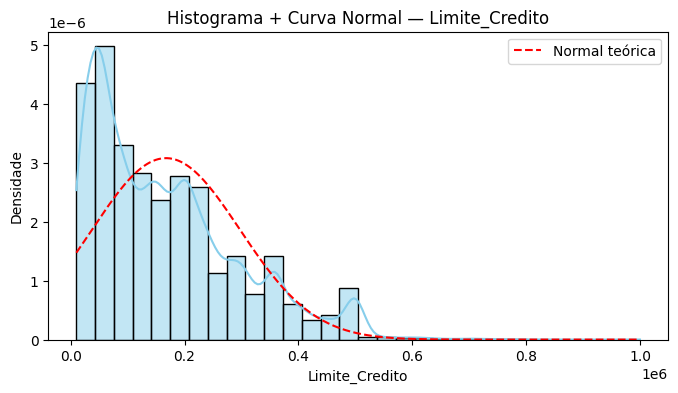

In [9]:
# Distribuição limite crédito
from scipy.stats import norm

col = "Limite_Credito"
data = df[col].dropna()
plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

O histograma evidencia que o Limite de Crédito apresenta uma distribuição assimétrica, com uma assimetria positiva acentuada (com cauda longa à direita), corrrespondente a um número reduzido de clientes com limites de crédito muito elevados.<br>
A curva normal teórica não se ajusta adequadamente à distribuição real dos dados, nomeadamente na região central (onde as observações são superiores às esperadas pela normal teórica) e na cauda à direita, onde verificamos valores extremos que não são considerados na normal teórica.

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

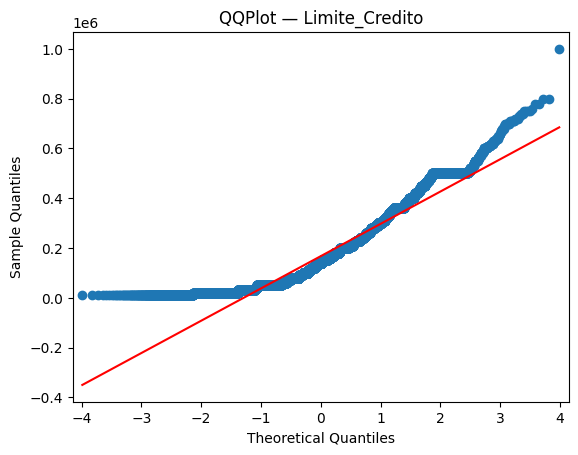

In [10]:
# QQ Plot Limite_Crédito
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

O QQPlot acima compara os quantis  da variável "Limite_Crédito" com os quantis teóricos de uma distribuição normal (linha vermelha), permitindo avaliar o grau de aderência à normalidade.<br>
Verificamos um desvio em relação à linha de referência sobretudo nas extremidades da distribuição. Na região central as observações (pontos azuis) aproximam-se parcialmente da reta. <br>
Nos quanties inferiores verificamos um afastamento da reta, o que é consistente com limites de crédito próximos de zero para uma parte considerável da amostra.

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Limite de Crédito segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Limite de Crédito não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [11]:
from scipy.stats import kstest, norm

# 'data' já contém a série 'Limite_Credito'
# Precisamos especificar a distribuição contra a qual queremos testar (normal)
# e os parâmetros da normal (média e desvio padrão de 'data').

mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Limite_Credito NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Limite_Credito SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.1151
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Limite_Credito NÃO segue uma distribuição normal.


Efetuei o teste de Kolmogorov-Smirnov com o objetivo de avaliar a hipótese de normalidade da variável "Limite_Crédito", por forma a complementar a análise gráfica realizada anteriormente (JHistograma e QQ plot).<br>
Este teste compara a distribuição empírica dos dados com uma distribuição normal teórica, com a mesma média e desvio-padrão, permitindo verificar se as diferenças observadas são estatisticamente significativas.

A hipótese nula do teste (𝐻0) assume que a variável segue uma distribuição normal.
No entanto, o valor-p obtido é praticamente nulo (𝑝<0.05), o que conduz à rejeição da hipótese nula ao nível de significância de 5%.

Este resultado indica que as diferenças entre a distribuição observada do "Limite_Crédito"" e uma distribuição normal não são atribuíveis ao acaso, confirmando estatisticamente que a variável não segue uma distribuição normal.

#### Identificação de Outliers usando o Método IQR para `Limite_Credito`

In [12]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Limite_Credito'].quantile(0.25)
Q3 = df['Limite_Credito'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Limite_Credito'] < lower_bound) | (df['Limite_Credito'] > upper_bound)]['Limite_Credito']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 50000.0
Q3 (75º percentil): 240000.0
IQR: 190000.0
Limite Inferior para Outliers: -235000.0
Limite Superior para Outliers: 525000.0
Número de Outliers identificados: 167


12     630000
433    580000
451    600000
527    620000
555    630000
Name: Limite_Credito, dtype: int64

Tendo em conta que a variável "Limite_Crédito" apresenta uma assimetria positiva e cauda longa à direita, o método do IQR é mais adequado do que abordagens baseadas na média e no desvio-padrão, que são fortemente influenciadas por outliers.<br>
O método do IQR avalia a dispersão central dos dados, concentrando-se nos 50% centrais da distribuição:
- Q1 (25º percentil): 50 000<br>
- Q3 (75º percentil): 240 000<br>
- IQR = Q3 − Q1 = 190 000<br>
<br>
Outliers são observações que se afastam significativamente do padrão geral dos dados.<br>
Estes outliers podem representar comportamentos extremos (fora do padrão mas que de facto ocorreram) ou erros de registo ou de medição.<br>
Neste caso concreto os outleiers observados estão localizados acima do limite superior. Estes outliers não indicam erros de registo, pois correspondem a outliers legítimos, associados a clientes com limites de crédito muito elevados.<br>
<br>
A identificação de outliers é fundamental, pois estes influenciam fortemente a média e o desvio padrão, e têm forte impacto na estabilidade de modelos sensivei a outliers, como é o caso da Regressão Logística.<br>
No estudo e interpretação dos outliers deve ser tido em conta se os mesmos devem ser mantidos, transformados, ou não considerados.

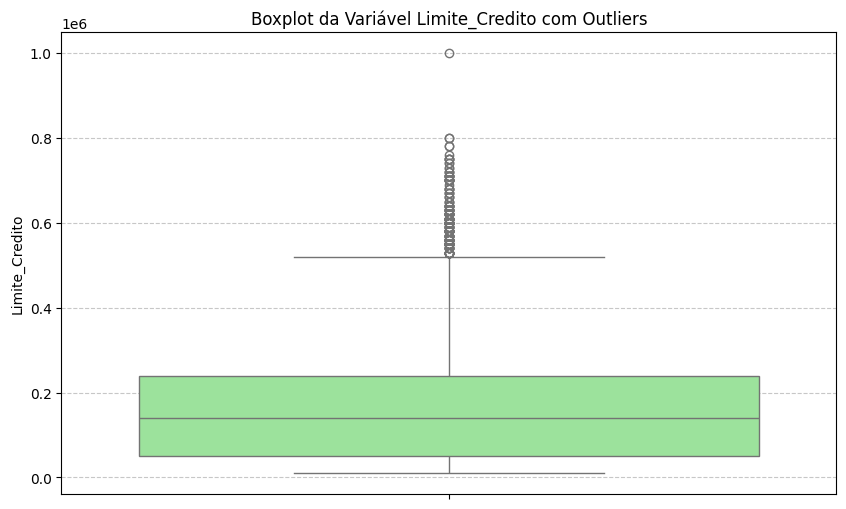

In [13]:
# Boxplot com outliers variável Limite_Crédito
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Limite_Credito'], color='lightgreen')
plt.title('Boxplot da Variável Limite_Credito com Outliers')
plt.ylabel('Limite_Credito')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

O Boxplot apresentado acima vem complementar a análise realizada anteriormente, permitindo visualizar gráficamente a distribuiçãoda variável, identificar medidas de tendencia central, dispersão, e presença de outliers.<br>
O boxplot permite observar:<br>
- Mediana: representada pela linha central da caixa, indicando o valor típico da variável.<br>
- Primeiro e terceiro quartis (Q1 e Q3): delimitam a caixa e representam os 50% centrais dos dados.<br>
- Intervalo interquartil (IQR): corresponde à altura da caixa e indica a dispersão dos valores centrais.<br>
- Extremos: mostram os valores mínimos e máximos considerados não atípicos.<br>
- Outliers: pontos individuais fora extremos, correspondendo a observações extremas segundo o critério do IQR.<br>

### Análise Variável Escolaridade

Na variável escolaridade (categórica) efetuei a análise obtendo um gráfico de barras, por forma a conseguir ver a distribuição dos nível de escolaridade, de seguida obtive a frequência absoluta e a frequência relativa de cada nível de escolaridade, e por fim a moda.

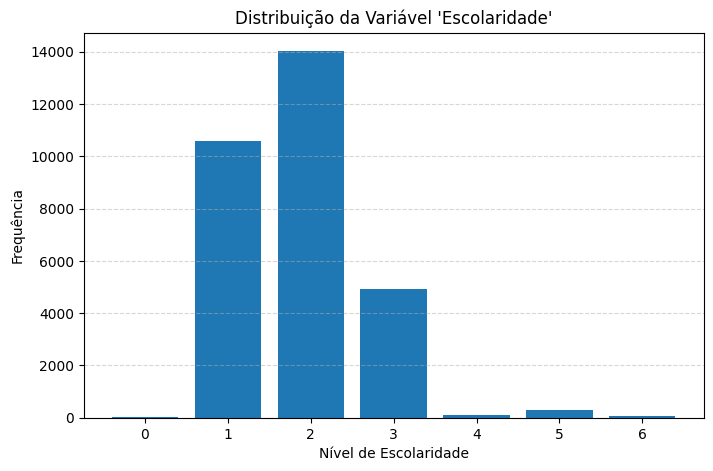

In [14]:
counts = df['Escolaridade'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Escolaridade'")
plt.xlabel("Nível de Escolaridade")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()



**Escolaridade**: (1=Ensino Básico, 2=Ensino Universitário, 3=Ensino Secundário, 4=others, 5=desconhecido, 6=desconhecido)

In [15]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Escolaridade'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Escolaridade'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

              Frequência Absoluta  Frequência Relativa (%)
Escolaridade                                              
0                              14                 0.046667
1                           10585                35.283333
2                           14030                46.766667
3                            4917                16.390000
4                             123                 0.410000
5                             280                 0.933333
6                              51                 0.170000


In [16]:
moda = df['Escolaridade'].mode()[0]
print("Moda da variável Escolaridade:", moda)

Moda da variável Escolaridade: 2


### Análise Variável Estado_Civil

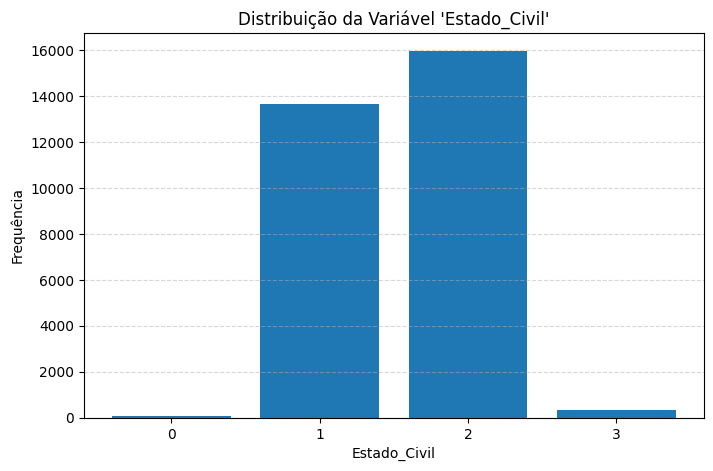

In [17]:
counts = df['Estado_Civil'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Estado_Civil'")
plt.xlabel("Estado_Civil")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Estado Civil**: (1=Casado, 2=Solteiro, 3=others)

In [18]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Estado_Civil'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Estado_Civil'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

              Frequência Absoluta  Frequência Relativa (%)
Estado_Civil                                              
0                              54                 0.180000
1                           13659                45.530000
2                           15964                53.213333
3                             323                 1.076667


In [19]:
moda = df['Estado_Civil'].mode()[0]
print("Moda da variável Estado_Civil:", moda)

Moda da variável Estado_Civil: 2


### Análise Variável Idade 

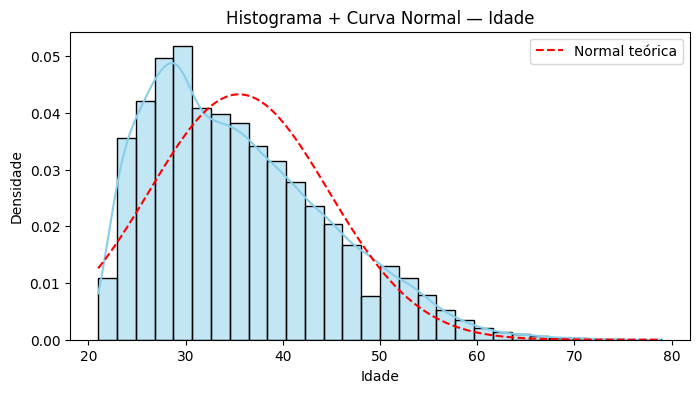

In [20]:
# Distribuição Idade
from scipy.stats import norm

col = "Idade"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

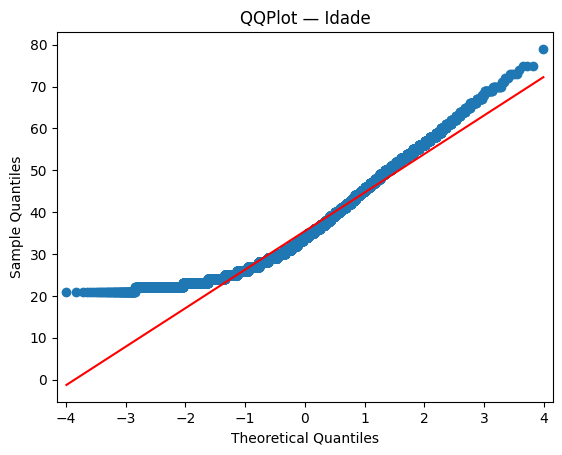

In [21]:
# QQ Plot Idade
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Idade segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Idade não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [22]:
# O teste de shapiro-wilk seria o mais indicado para a variável idade, mas utilizarei kstest devido à dimensão do data set (30 000 registos)

mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Idade NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Idade SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.0945
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Idade NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Idade`

In [23]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Idade'].quantile(0.25)
Q3 = df['Idade'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Idade'] < lower_bound) | (df['Idade'] > upper_bound)]['Idade']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 28.0
Q3 (75º percentil): 41.0
IQR: 13.0
Limite Inferior para Outliers: 8.5
Limite Superior para Outliers: 60.5
Número de Outliers identificados: 272


102     63.0
246     75.0
366     61.0
387     73.0
1029    67.0
Name: Idade, dtype: float64

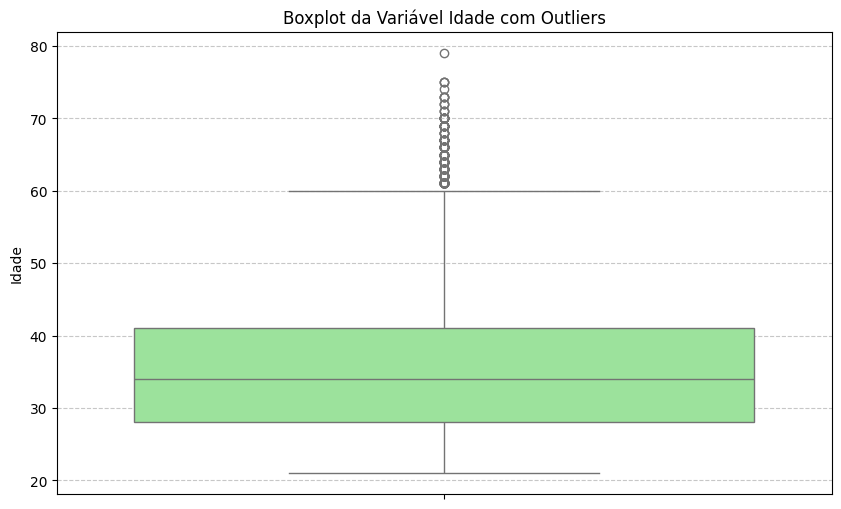

In [24]:
# Boxplot com outliers variável Idade
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Idade'], color='lightgreen')
plt.title('Boxplot da Variável Idade com Outliers')
plt.ylabel('Idade')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Atraso_Pagamento_Setembro

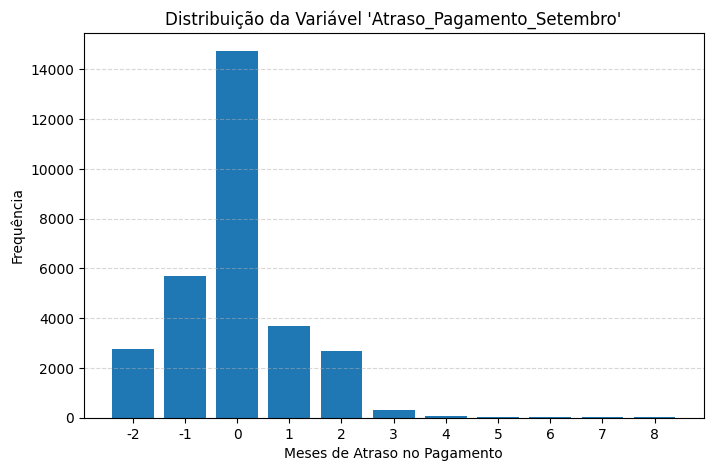

In [25]:
counts = df['Atraso_Pagamento_Setembro'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Setembro'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [26]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Setembro'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Setembro'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                           Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Setembro                                              
-2                                        2759                 9.196667
-1                                        5686                18.953333
 0                                       14737                49.123333
 1                                        3688                12.293333
 2                                        2667                 8.890000
 3                                         322                 1.073333
 4                                          76                 0.253333
 5                                          26                 0.086667
 6                                          11                 0.036667
 7                                           9                 0.030000
 8                                          19                 0.063333


In [27]:
moda = df['Atraso_Pagamento_Setembro'].mode()[0]
print("Moda da variável Atraso_Pagamento_Setembro:", moda)

Moda da variável Atraso_Pagamento_Setembro: 0


### Análise Variável Atraso_Pagamento_Agosto 

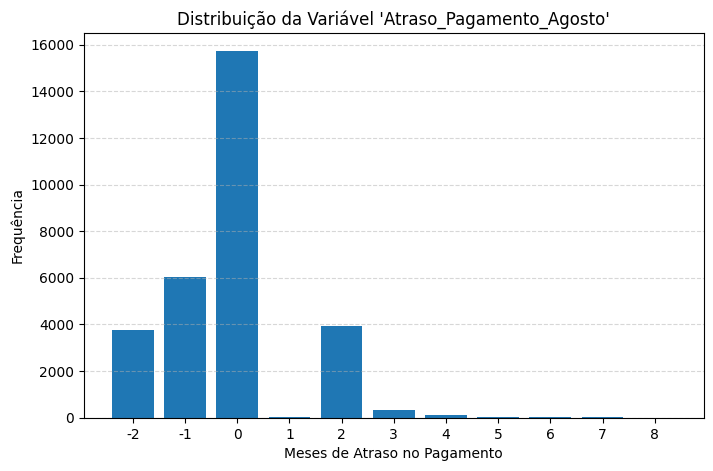

In [28]:
counts = df['Atraso_Pagamento_Agosto'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Agosto'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [29]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Agosto'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Agosto'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                         Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Agosto                                              
-2                                      3782                12.606667
-1                                      6050                20.166667
 0                                     15730                52.433333
 1                                        28                 0.093333
 2                                      3927                13.090000
 3                                       326                 1.086667
 4                                        99                 0.330000
 5                                        25                 0.083333
 6                                        12                 0.040000
 7                                        20                 0.066667
 8                                         1                 0.003333


In [30]:
moda = df['Atraso_Pagamento_Agosto'].mode()[0]
print("Moda da variável Atraso_Pagamento_Agosto:", moda)

Moda da variável Atraso_Pagamento_Agosto: 0


### Análise Variável Atraso_Pagamento_Julho 

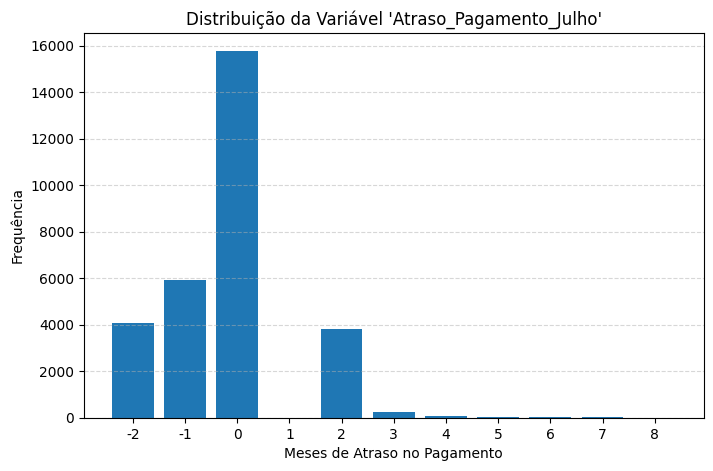

In [31]:
counts = df['Atraso_Pagamento_Julho'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Julho'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [32]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Julho'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Julho'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                        Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Julho                                              
-2                                     4085                13.616667
-1                                     5938                19.793333
 0                                    15764                52.546667
 1                                        4                 0.013333
 2                                     3819                12.730000
 3                                      240                 0.800000
 4                                       76                 0.253333
 5                                       21                 0.070000
 6                                       23                 0.076667
 7                                       27                 0.090000
 8                                        3                 0.010000


In [33]:
moda = df['Atraso_Pagamento_Julho'].mode()[0]
print("Moda da variável Atraso_Pagamento_Julho:", moda)

Moda da variável Atraso_Pagamento_Julho: 0


### Análise Variável Atraso_Pagamento_Junho 

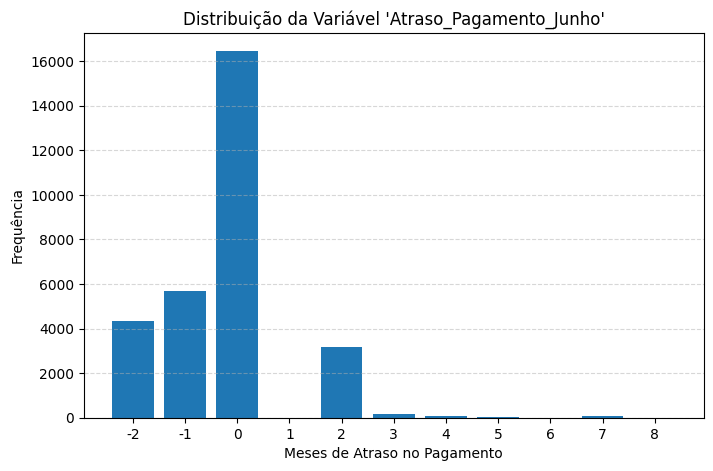

In [34]:
counts = df['Atraso_Pagamento_Junho'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Junho'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [35]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Junho'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Junho'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                        Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Junho                                              
-2                                     4348                14.493333
-1                                     5687                18.956667
 0                                    16455                54.850000
 1                                        2                 0.006667
 2                                     3159                10.530000
 3                                      180                 0.600000
 4                                       69                 0.230000
 5                                       35                 0.116667
 6                                        5                 0.016667
 7                                       58                 0.193333
 8                                        2                 0.006667


In [36]:
moda = df['Atraso_Pagamento_Junho'].mode()[0]
print("Moda da variável Atraso_Pagamento_Junho:", moda)

Moda da variável Atraso_Pagamento_Junho: 0


### Análise Variável Atraso_Pagamento_Maio 

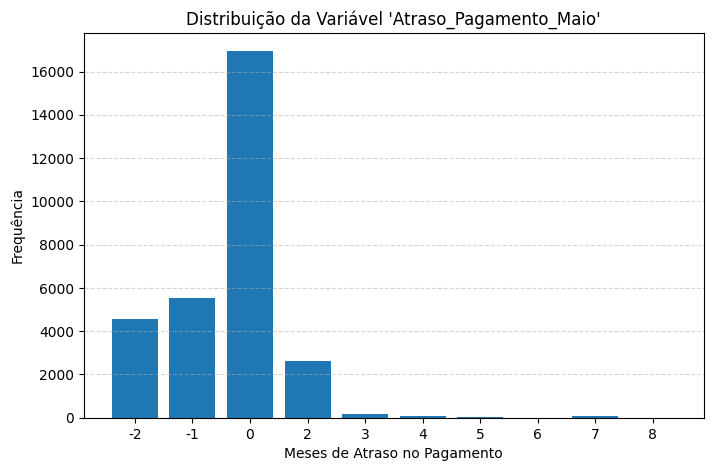

In [37]:
counts = df['Atraso_Pagamento_Maio'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Maio'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [38]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Maio'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Maio'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                       Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Maio                                              
-2                                    4546                15.153333
-1                                    5539                18.463333
 0                                   16947                56.490000
 2                                    2626                 8.753333
 3                                     178                 0.593333
 4                                      84                 0.280000
 5                                      17                 0.056667
 6                                       4                 0.013333
 7                                      58                 0.193333
 8                                       1                 0.003333


In [39]:
moda = df['Atraso_Pagamento_Maio'].mode()[0]
print("Moda da variável Atraso_Pagamento_Maio:", moda)

Moda da variável Atraso_Pagamento_Maio: 0


### Análise Variável Atraso_Pagamento_Abril 

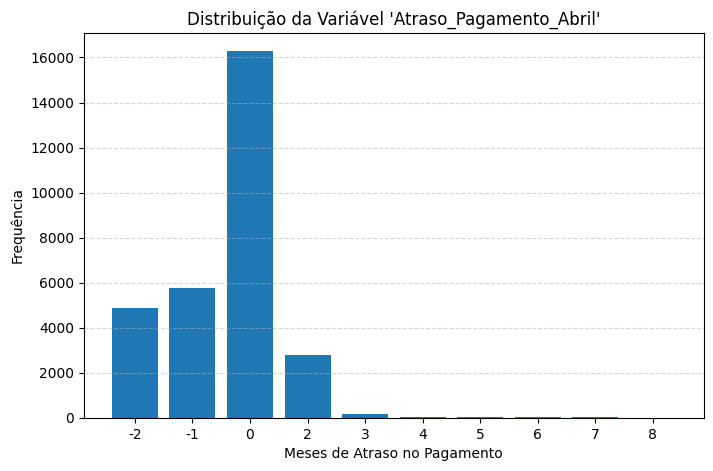

In [40]:
counts = df['Atraso_Pagamento_Abril'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Atraso_Pagamento_Abril'")
plt.xlabel("Meses de Atraso no Pagamento")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [41]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Atraso_Pagamento_Abril'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Atraso_Pagamento_Abril'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                        Frequência Absoluta  Frequência Relativa (%)
Atraso_Pagamento_Abril                                              
-2                                     4895                16.316667
-1                                     5740                19.133333
 0                                    16286                54.286667
 2                                     2766                 9.220000
 3                                      184                 0.613333
 4                                       49                 0.163333
 5                                       13                 0.043333
 6                                       19                 0.063333
 7                                       46                 0.153333
 8                                        2                 0.006667


In [42]:
moda = df['Atraso_Pagamento_Abril'].mode()[0]
print("Moda da variável Atraso_Pagamento_Abril:", moda)

Moda da variável Atraso_Pagamento_Abril: 0


### Análise Variável Fatura_Setembro 

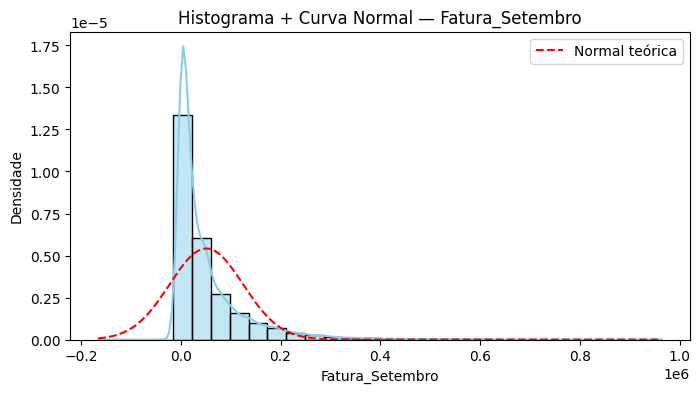

In [43]:
# Distribuição Farura_Setembro
from scipy.stats import norm

col = "Fatura_Setembro"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

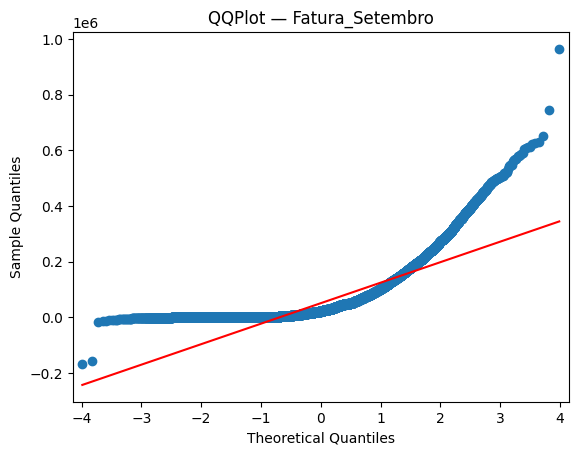

In [44]:
# QQ Plot Fatura_Setembro
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Setembro segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Setembro não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [45]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Setembro NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Setembro SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2367
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Setembro NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Setembro`

In [46]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Setembro'].quantile(0.25)
Q3 = df['Fatura_Setembro'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Setembro'] < lower_bound) | (df['Fatura_Setembro'] > upper_bound)]['Fatura_Setembro']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 3558.75
Q3 (75º percentil): 67091.0
IQR: 63532.25
Limite Inferior para Outliers: -91739.625
Limite Superior para Outliers: 162389.375
Número de Outliers identificados: 2400


6     367965
17    253286
36    186503
40    218668
57    175886
Name: Fatura_Setembro, dtype: int64

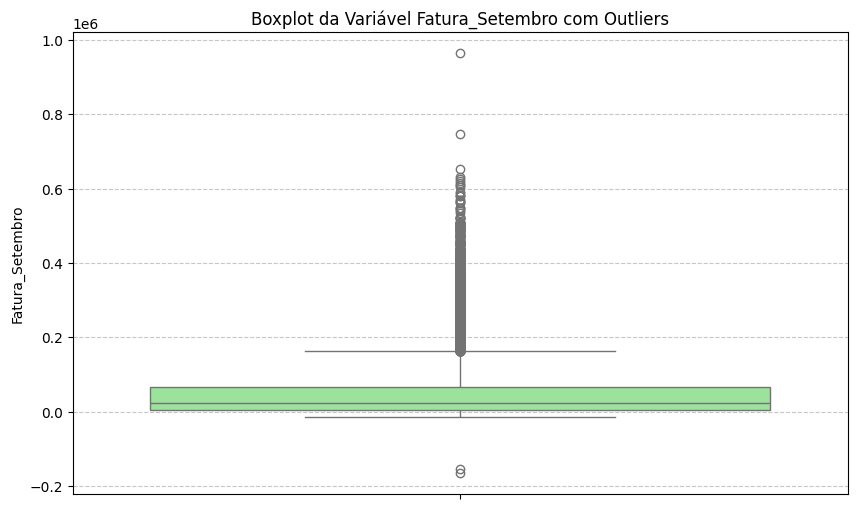

In [47]:
# Boxplot com outliers variável Fatura_Setembro
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Setembro'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Setembro com Outliers')
plt.ylabel('Fatura_Setembro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Fatura_Agosto

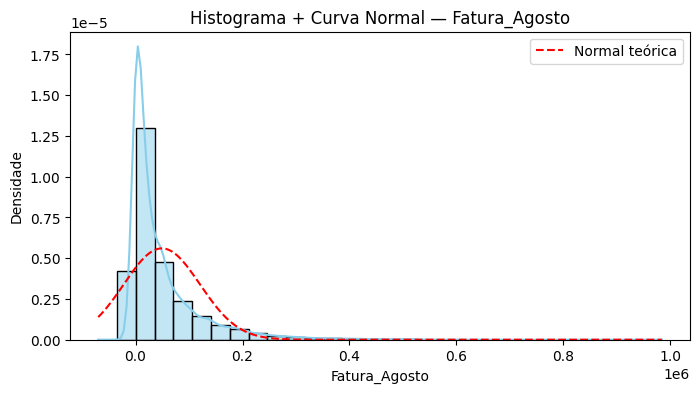

In [48]:
# Distribuição Farura_Agosto
from scipy.stats import norm

col = "Fatura_Agosto"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

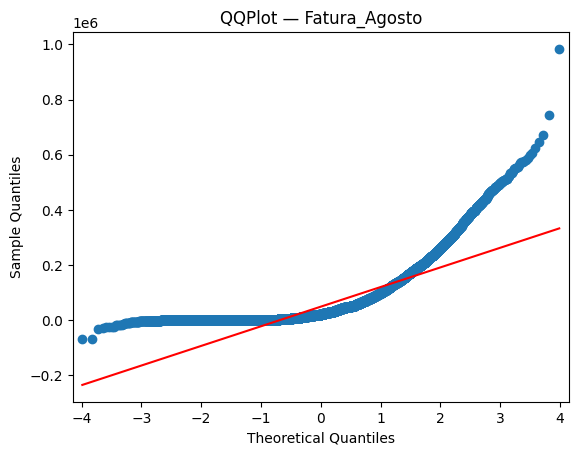

In [49]:
# QQ Plot Fatura_Agosto
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Agosto segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Agosto não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [50]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Agosto NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Agosto SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2369
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Agosto NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Agosto`

In [51]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Agosto'].quantile(0.25)
Q3 = df['Fatura_Agosto'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Agosto'] < lower_bound) | (df['Fatura_Agosto'] > upper_bound)]['Fatura_Agosto']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 2984.75
Q3 (75º percentil): 64006.25
IQR: 61021.5
Limite Inferior para Outliers: -88547.5
Limite Superior para Outliers: 155538.5
Número de Outliers identificados: 2395


6     412023
17    246536
36    181328
40    221296
57    173440
Name: Fatura_Agosto, dtype: int64

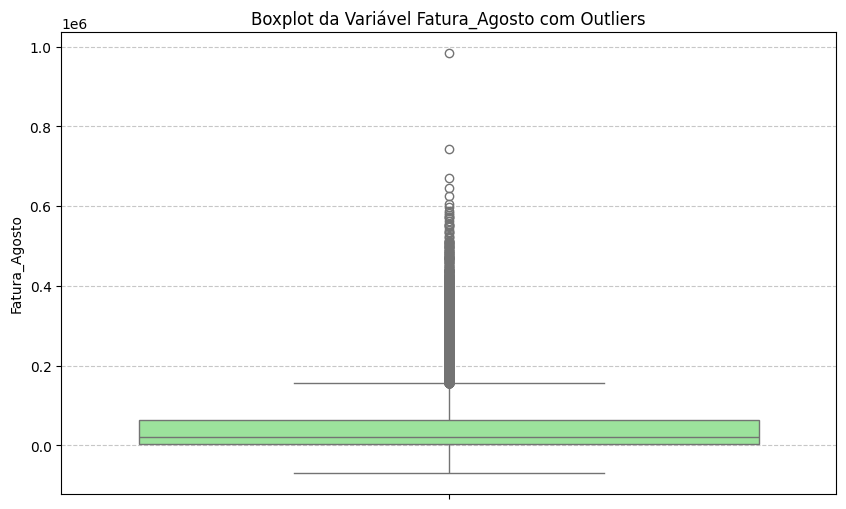

In [52]:
# Boxplot com outliers variável Fatura_Agosto
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Agosto'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Agosto com Outliers')
plt.ylabel('Fatura_Agosto')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Fatura_Julho

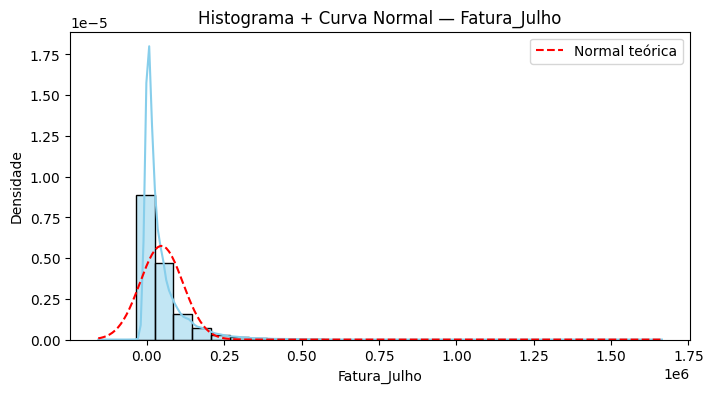

In [53]:
# Distribuição Farura_Julho
from scipy.stats import norm

col = "Fatura_Julho"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

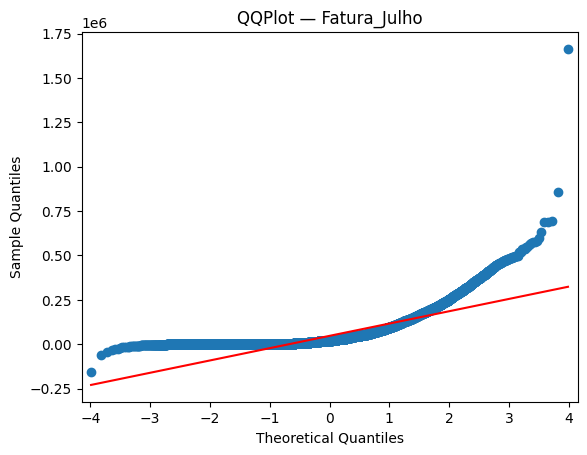

In [54]:
# QQ Plot Fatura_JUlho
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Julho segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Julho não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [55]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Julho NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Julho SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2400
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Julho NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Julho`

In [56]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Julho'].quantile(0.25)
Q3 = df['Fatura_Julho'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Julho'] < lower_bound) | (df['Fatura_Julho'] > upper_bound)]['Fatura_Julho']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 2666.25
Q3 (75º percentil): 60164.75
IQR: 57498.5
Limite Inferior para Outliers: -83581.5
Limite Superior para Outliers: 146412.5
Número de Outliers identificados: 2469


6     445007
17    194663
36    180422
40    206895
57    172308
Name: Fatura_Julho, dtype: int64

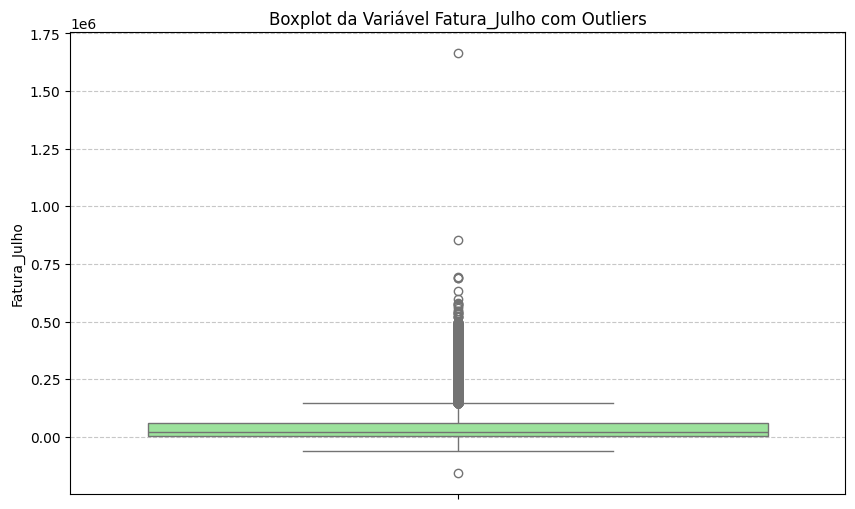

In [57]:
# Boxplot com outliers variável Fatura_Julho
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Julho'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Julho com Outliers')
plt.ylabel('Fatura_Julho')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Fatura_Junho 

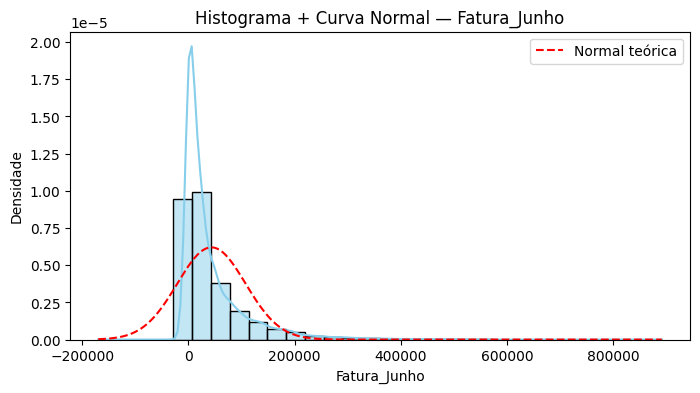

In [58]:
# Distribuição Farura_Julho
from scipy.stats import norm

col = "Fatura_Junho"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

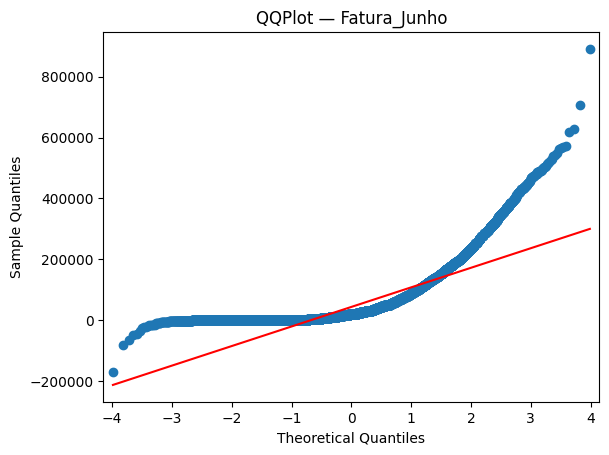

In [59]:
# QQ Plot Fatura_Junho
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Junho segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Junho não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [60]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Junho NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Junho SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2408
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Junho NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Junho`

In [61]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Junho'].quantile(0.25)
Q3 = df['Fatura_Junho'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Junho'] < lower_bound) | (df['Fatura_Junho'] > upper_bound)]['Fatura_Junho']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 2326.75
Q3 (75º percentil): 54506.0
IQR: 52179.25
Limite Inferior para Outliers: -75942.125
Limite Superior para Outliers: 132774.875
Número de Outliers identificados: 2622


6     542653
36    170410
40    628699
57    168608
59    360199
Name: Fatura_Junho, dtype: int64

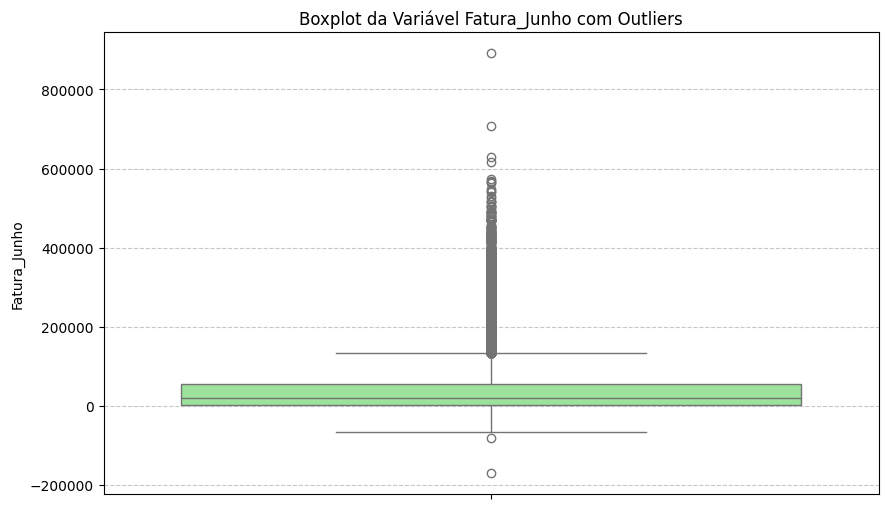

In [62]:
# Boxplot com outliers variável Fatura_Junho
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Junho'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Junho com Outliers')
plt.ylabel('Fatura_Junho')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Fatura_Maio 

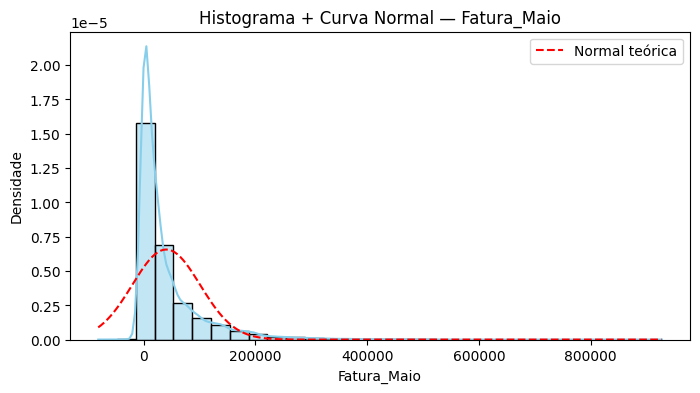

In [63]:
# Distribuição Farura_Maio
from scipy.stats import norm

col = "Fatura_Maio"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

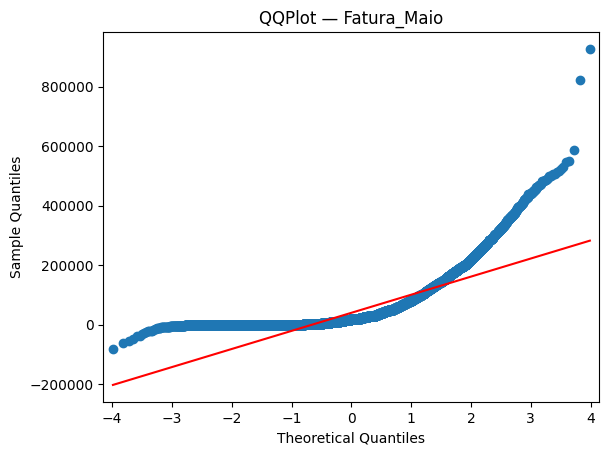

In [64]:
# QQ Plot Fatura_Maio
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Maio segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Maio não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [65]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Maio NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Maio SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2435
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Maio NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Maio`

In [66]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Maio'].quantile(0.25)
Q3 = df['Fatura_Maio'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Maio'] < lower_bound) | (df['Fatura_Maio'] > upper_bound)]['Fatura_Maio']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 1763.0
Q3 (75º percentil): 50190.5
IQR: 48427.5
Limite Inferior para Outliers: -70878.25
Limite Superior para Outliers: 122831.75
Número de Outliers identificados: 2725


6     483003
36    173901
40    195969
57    132202
59    356656
Name: Fatura_Maio, dtype: int64

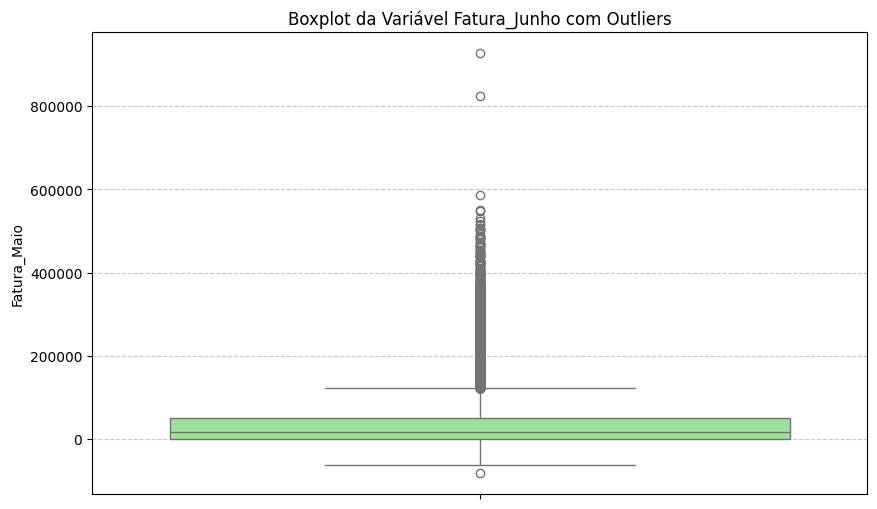

In [67]:
# Boxplot com outliers variável Fatura_Maio
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Maio'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Junho com Outliers')
plt.ylabel('Fatura_Maio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Fatura_Abril

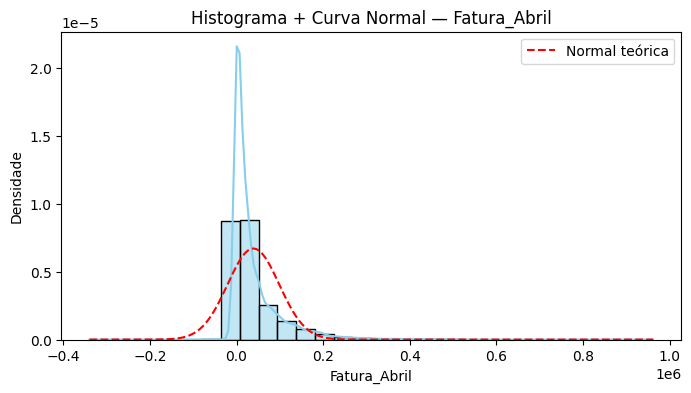

In [68]:
# Distribuição Farura_Abril
from scipy.stats import norm

col = "Fatura_Abril"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")
plt.legend()
plt.show()

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

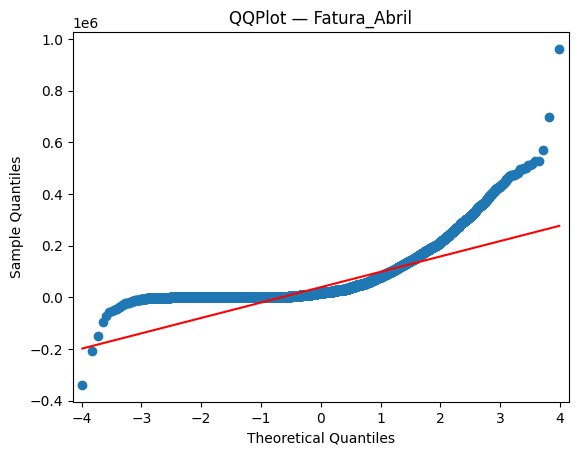

In [69]:
# QQ Plot Fatura_Abril
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Fatura_Abril segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Fatura_Abril não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [70]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Fatura_Abril NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Fatura_Abril SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.2458
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Fatura_Abril NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Fatura_Abril`

In [71]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Fatura_Abril'].quantile(0.25)
Q3 = df['Fatura_Abril'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Fatura_Abril'] < lower_bound) | (df['Fatura_Abril'] > upper_bound)]['Fatura_Abril']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 1256.0
Q3 (75º percentil): 49198.25
IQR: 47942.25
Limite Inferior para Outliers: -70657.375
Limite Superior para Outliers: 121111.625
Número de Outliers identificados: 2693


6     473944
17    195599
36    177413
40    179224
57    129918
Name: Fatura_Abril, dtype: int64

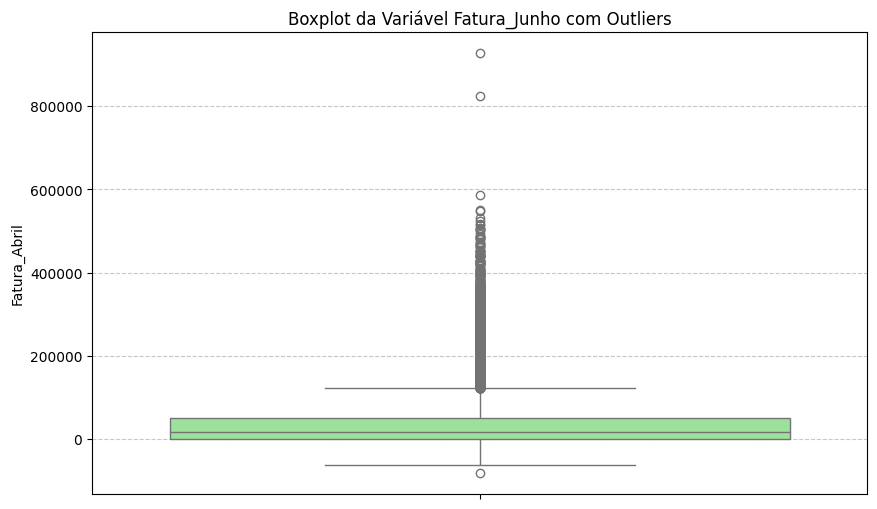

In [72]:
# Boxplot com outliers variável Fatura_Abril
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Fatura_Maio'], color='lightgreen')
plt.title('Boxplot da Variável Fatura_Junho com Outliers')
plt.ylabel('Fatura_Abril')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Setembro 

Text(0, 0.5, 'Densidade')

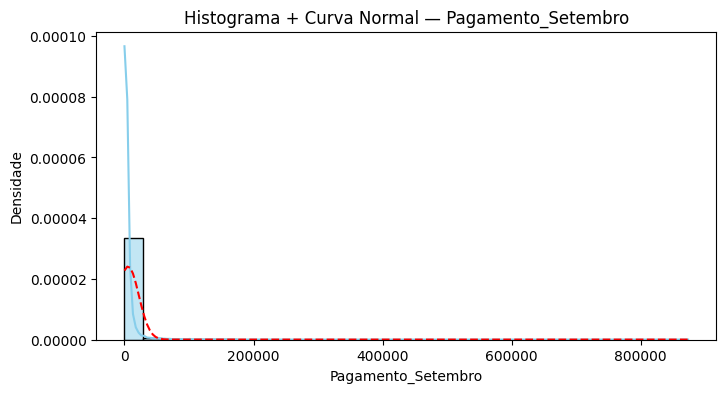

In [73]:
# Distribuição Pagamento_Setembro
from scipy.stats import norm

col = "Pagamento_Setembro"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 800x400 with 0 Axes>

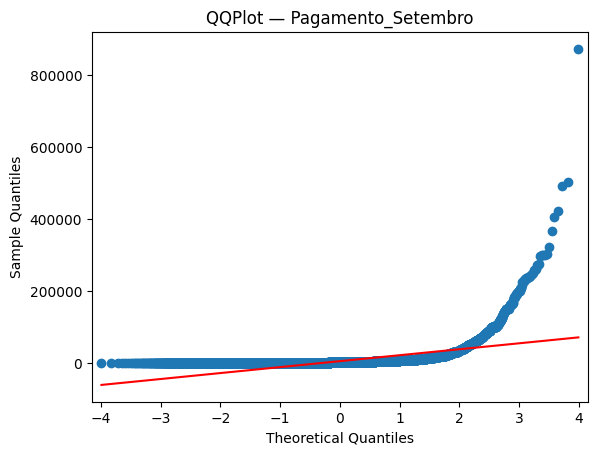

In [74]:
# QQ Plot Pagamento_Setembro
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

plt.show()

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Setembro segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Setembro não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [75]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Setembro NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Setembro SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3662
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Setembro NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Setembro`

In [76]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Setembro'].quantile(0.25)
Q3 = df['Pagamento_Setembro'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Setembro'] < lower_bound) | (df['Pagamento_Setembro'] > upper_bound)]['Pagamento_Setembro']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 1000.0
Q3 (75º percentil): 5006.0
IQR: 4006.0
Limite Inferior para Outliers: -5009.0
Limite Superior para Outliers: 11015.0
Número de Outliers identificados: 2745


6     55000
11    21818
23    19428
30    17270
48    21540
Name: Pagamento_Setembro, dtype: int64

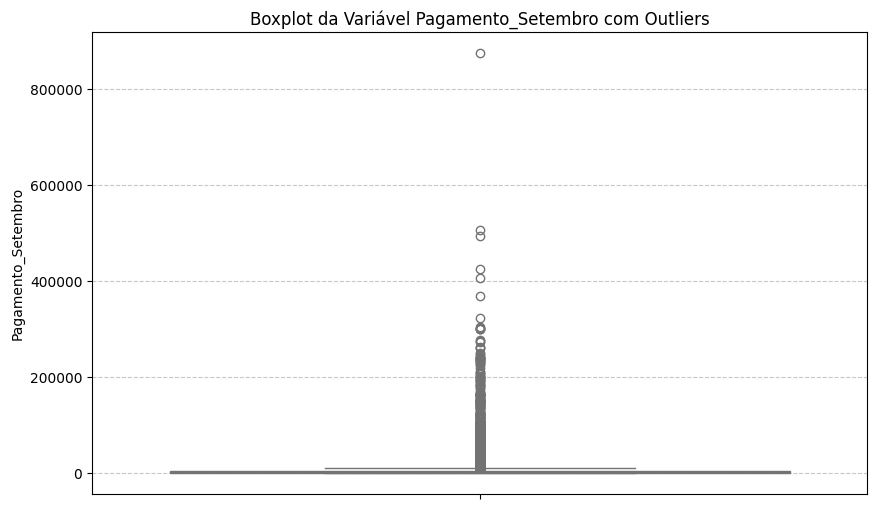

In [77]:
# Boxplot com outliers variável Fatura_Abril
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Setembro'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Setembro com Outliers')
plt.ylabel('Pagamento_Setembro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Agosto 

Text(0, 0.5, 'Densidade')

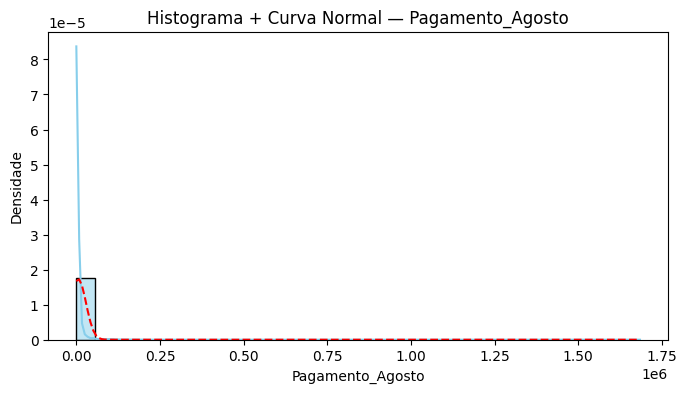

In [78]:
# Distribuição Pagamento_Agosto
col = "Pagamento_Agosto"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQPlot — Pagamento_Agosto')

<Figure size 800x400 with 0 Axes>

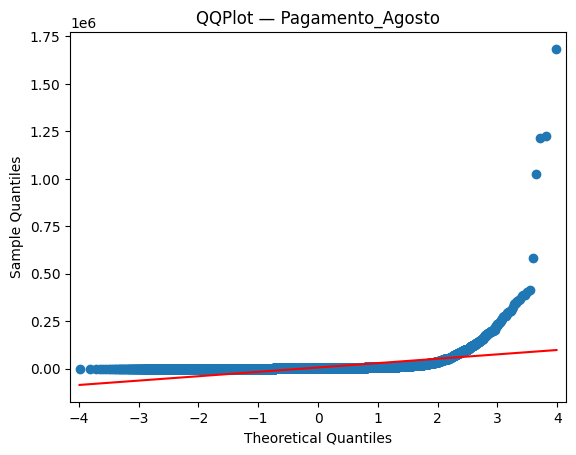

In [79]:
# QQ Plot Pagamento_Agosto
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Agosto segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Agosto não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [80]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Agosto NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Agosto SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3986
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Agosto NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Agosto`

In [81]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Agosto'].quantile(0.25)
Q3 = df['Pagamento_Agosto'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Agosto'] < lower_bound) | (df['Pagamento_Agosto'] > upper_bound)]['Pagamento_Agosto']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 833.0
Q3 (75º percentil): 5000.0
IQR: 4167.0
Limite Inferior para Outliers: -5417.5
Limite Superior para Outliers: 11250.5
Número de Outliers identificados: 2714


4     36681
6     40000
30    13281
33    22827
34    31178
Name: Pagamento_Agosto, dtype: int64

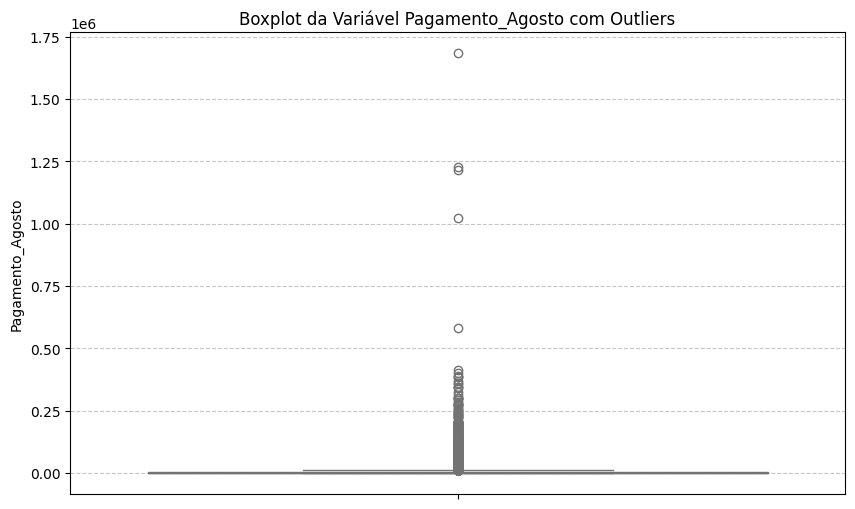

In [82]:
# Boxplot com outliers variável Pagamento_Agosto
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Agosto'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Agosto com Outliers')
plt.ylabel('Pagamento_Agosto')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Julho 

Text(0, 0.5, 'Densidade')

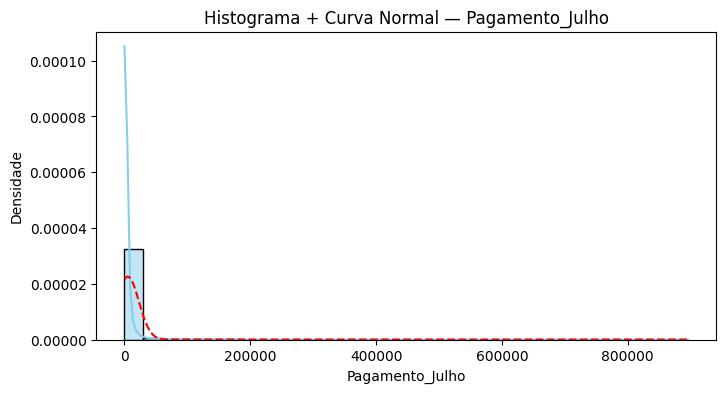

In [83]:
# Distribuição Pagamento_Julho
col = "Pagamento_Julho"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQPlot — Pagamento_Julho')

<Figure size 800x400 with 0 Axes>

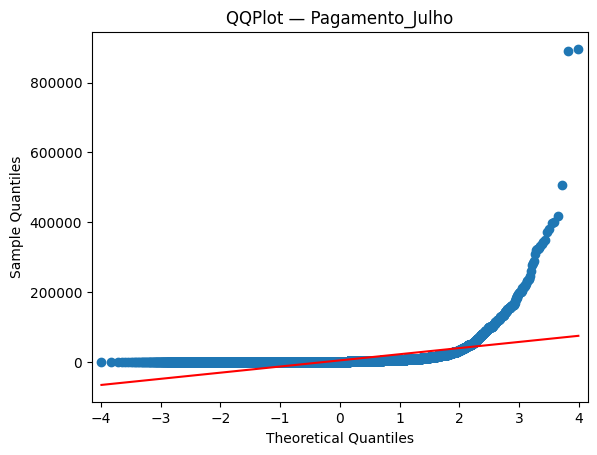

In [84]:
# QQ Plot Pagamento_Julho
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Julho segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Julho não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [85]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Julho NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Julho SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3833
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Julho NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Julho`

In [86]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Julho'].quantile(0.25)
Q3 = df['Pagamento_Julho'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Julho'] < lower_bound) | (df['Pagamento_Julho'] > upper_bound)]['Pagamento_Julho']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 390.0
Q3 (75º percentil): 4505.0
IQR: 4115.0
Limite Inferior para Outliers: -5782.5
Limite Superior para Outliers: 10677.5
Número de Outliers identificados: 2598


6     38000
17    75940
30    15339
46    16741
48    24677
Name: Pagamento_Julho, dtype: int64

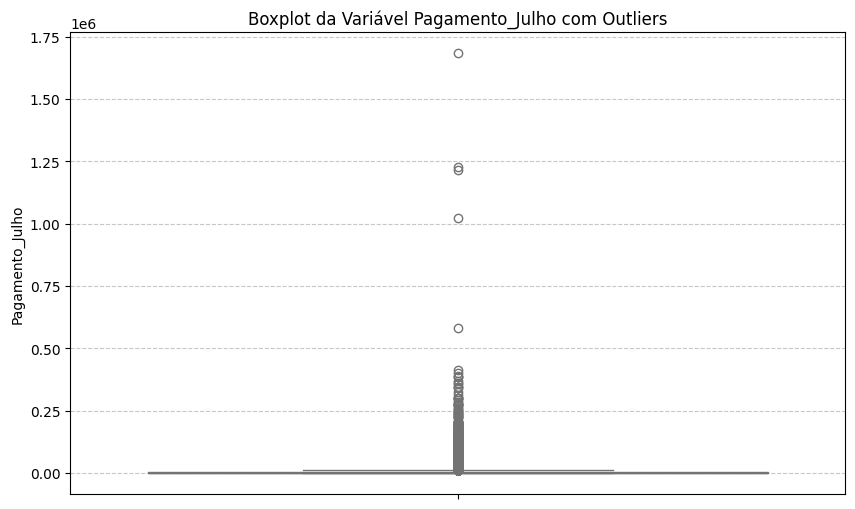

In [87]:
# Boxplot com outliers variável Pagamento_Julho
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Agosto'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Julho com Outliers')
plt.ylabel('Pagamento_Julho')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Junho 

Text(0, 0.5, 'Densidade')

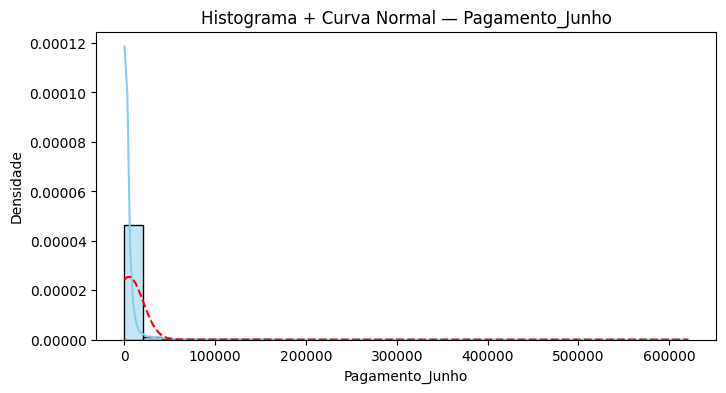

In [88]:
# Distribuição Pagamento_Junho
col = "Pagamento_Junho"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQPlot — Pagamento_Junho')

<Figure size 800x400 with 0 Axes>

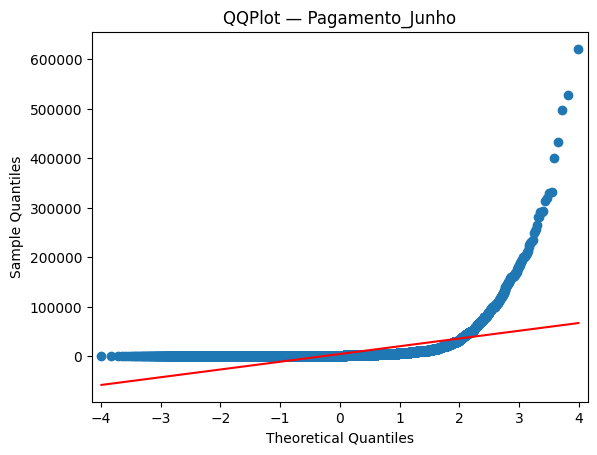

In [89]:
# QQ Plot Pagamento_Junho
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Junho segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Junho não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [90]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Junho NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Junho SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3790
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Junho NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Junho`

In [91]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Junho'].quantile(0.25)
Q3 = df['Pagamento_Junho'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Junho'] < lower_bound) | (df['Pagamento_Junho'] > upper_bound)]['Pagamento_Junho']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 296.0
Q3 (75º percentil): 4013.25
IQR: 3717.25
Limite Inferior para Outliers: -5279.875
Limite Superior para Outliers: 9589.125
Número de Outliers identificados: 2994


6     20239
9     13007
11    22301
17    20000
28    30430
Name: Pagamento_Junho, dtype: int64

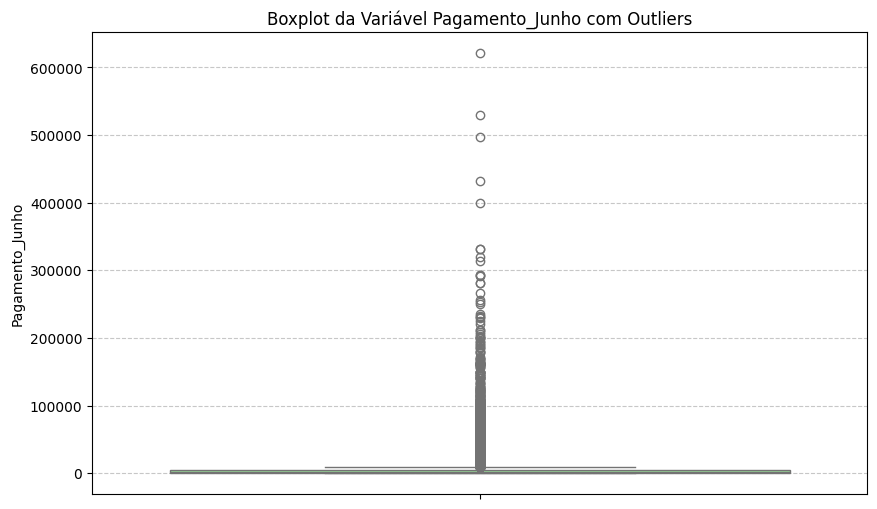

In [92]:
# Boxplot com outliers variável Pagamento_Junho
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Junho'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Junho com Outliers')
plt.ylabel('Pagamento_Junho')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Maio 

Text(0, 0.5, 'Densidade')

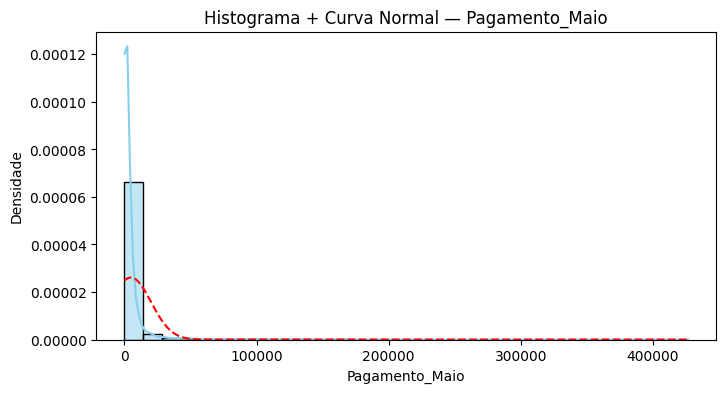

In [93]:
# Distribuição Pagamento_Maio
col = "Pagamento_Maio"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQPlot — Pagamento_Maio')

<Figure size 800x400 with 0 Axes>

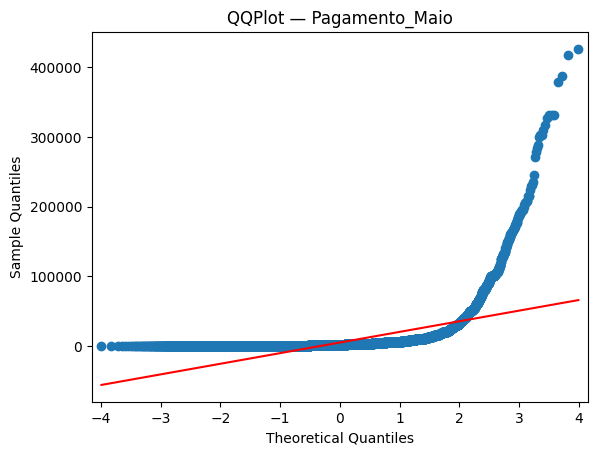

In [94]:
# QQ Plot Pagamento_Maio
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Maio segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Maio não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [95]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Maio NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Maio SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3767
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Maio NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Maio`

In [96]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Maio'].quantile(0.25)
Q3 = df['Pagamento_Maio'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Maio'] < lower_bound) | (df['Pagamento_Maio'] > upper_bound)]['Pagamento_Maio']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")

display(outliers.head()) # Exibe os primeiros outliers, se houver

Q1 (25º percentil): 252.5
Q3 (75º percentil): 4031.5
IQR: 3779.0
Limite Inferior para Outliers: -5416.0
Limite Superior para Outliers: 9700.0
Número de Outliers identificados: 2945


6      13750
17    195599
30     37292
37     47671
40     28000
Name: Pagamento_Maio, dtype: int64

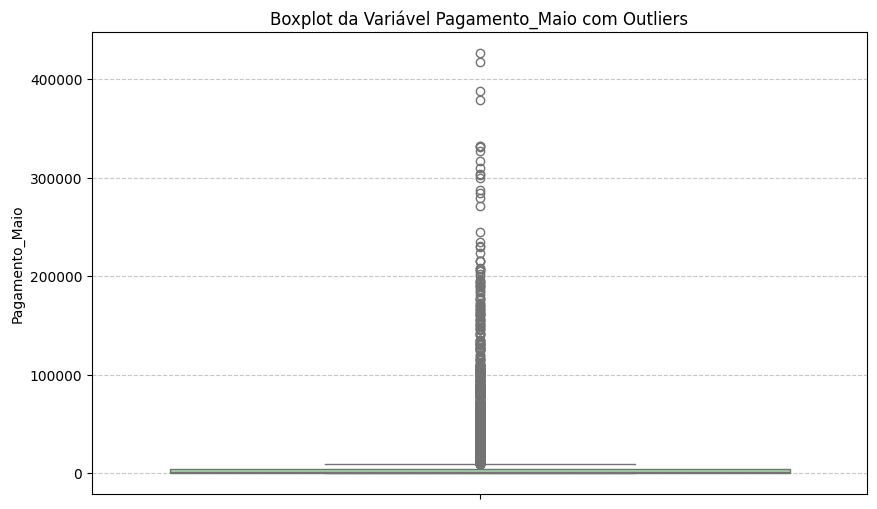

In [97]:
# Boxplot com outliers variável Pagamento_Maio
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Maio'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Maio com Outliers')
plt.ylabel('Pagamento_Maio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Pagamento_Abril 

Text(0, 0.5, 'Densidade')

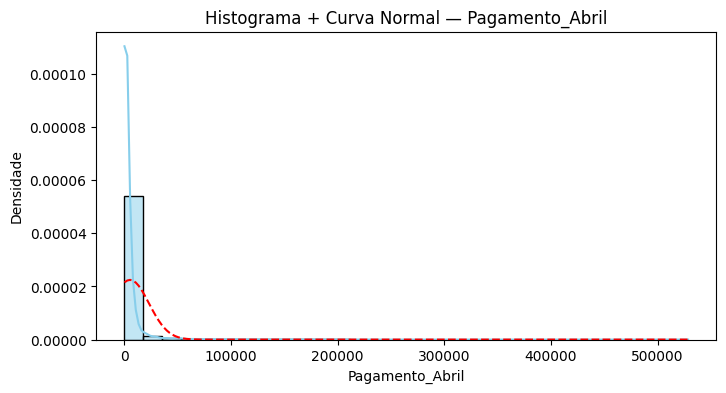

In [98]:
# Distribuição Pagamento_Abril
col = "Pagamento_Abril"
data = df[col].dropna()   # var = variável isolada, df = DataFrame completo

plt.figure(figsize=(8, 4))
sns.histplot(data, bins=30, kde=True, color='skyblue', stat='density')


mean = data.mean()
std = data.std()
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mean, std)

plt.plot(x, y, "r--", label="Normal teórica")
plt.title(f"Histograma + Curva Normal — {col}")
plt.xlabel(col)
plt.ylabel("Densidade")

c:\Users\hugof\OneDrive\Ambiente de Trabalho\Data Science\venv310\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'QQPlot — Pagamento_Abril')

<Figure size 800x400 with 0 Axes>

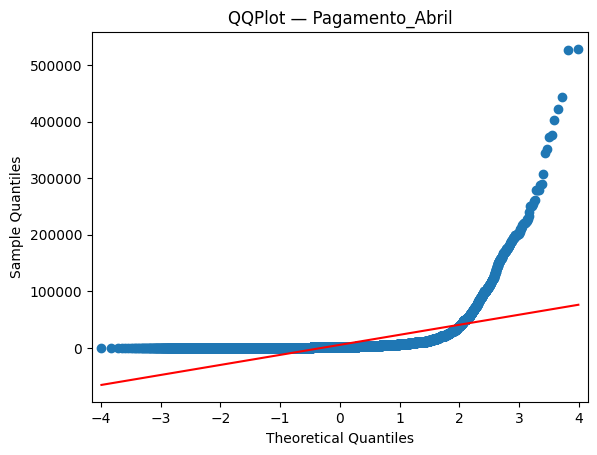

In [99]:
# QQ Plot Pagamento_Abril
plt.figure(figsize=(8, 4))
sm.qqplot(data=data, line="s", marker="o", color="blue")
plt.title(f"QQPlot — {col}")

#### Teste de hipóteses

Hipótese Nula (H0) = A variável Pagamento_Abril segue uma distribuição normal <BR> Hipótese Alternativa (H1) = A variável Pagamento_Abril não segue uma distribuição normal <br>
Quando o p-value > 0.05 aceitamos H0. <br>
Se o p-value <= 0.05 rejeitamos H0, logo não é normal.

In [100]:
mean_data = data.mean()
std_data = data.std()

stat, p_value = kstest(data, 'norm', args=(mean_data, std_data))

print(f"Estatística do teste de Kolmogorov-Smirnov: {stat:.4f}")
print(f"Valor-p: {p_value:.4f}")

alpha = 0.05 # Nível de significância

if p_value < alpha:
    print("Rejeitamos a hipótese nula (H0): A variável Pagamento_Abril NÃO segue uma distribuição normal.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula (H0): A variável Pagamento_Abril SEGUE uma distribuição normal.")

Estatística do teste de Kolmogorov-Smirnov: 0.3846
Valor-p: 0.0000
Rejeitamos a hipótese nula (H0): A variável Pagamento_Abril NÃO segue uma distribuição normal.


#### Identificação de Outliers usando o Método IQR para `Pagamento_Abril`

In [101]:
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = df['Pagamento_Abril'].quantile(0.25)
Q3 = df['Pagamento_Abril'].quantile(0.75)

# Calcular o Intervalo Interquartil (IQR)
IQR = Q3 - Q1

# Definir os limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = df[(df['Pagamento_Abril'] < lower_bound) | (df['Pagamento_Abril'] > upper_bound)]['Pagamento_Abril']

print(f"Q1 (25º percentil): {Q1}")
print(f"Q3 (75º percentil): {Q3}")
print(f"IQR: {IQR}")
print(f"Limite Inferior para Outliers: {lower_bound}")
print(f"Limite Superior para Outliers: {upper_bound}")
print(f"Número de Outliers identificados: {len(outliers)}")


Q1 (25º percentil): 117.75
Q3 (75º percentil): 4000.0
IQR: 3882.25
Limite Inferior para Outliers: -5705.625
Limite Superior para Outliers: 9823.375
Número de Outliers identificados: 2958


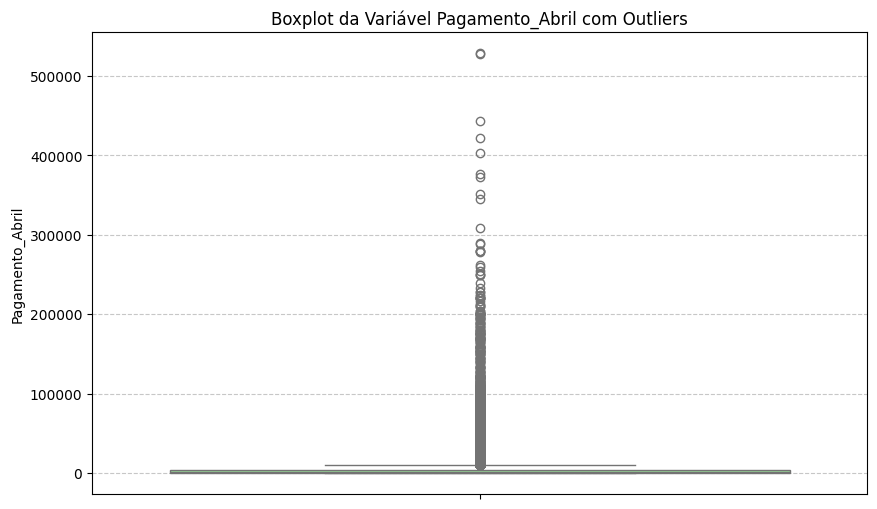

In [102]:
# Boxplot com outliers variável Pagamento_Abril
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Pagamento_Abril'], color='lightgreen')
plt.title('Boxplot da Variável Pagamento_Abril com Outliers')
plt.ylabel('Pagamento_Abril')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análise Variável Incumprimento_Mes_Seguinte

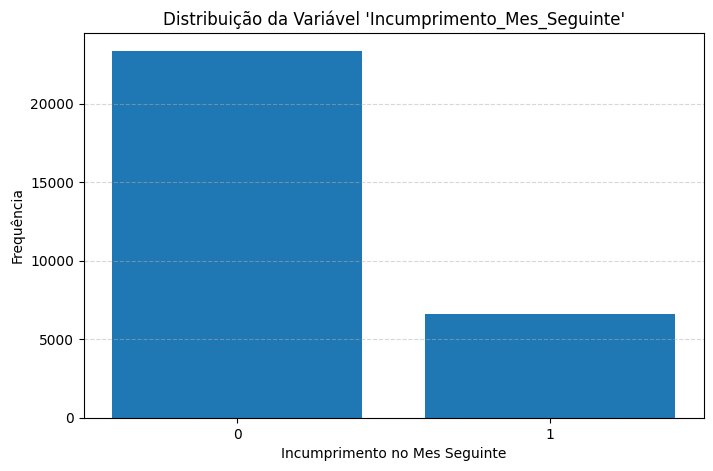

In [103]:
counts = df['Incumprimento_Mes_Seguinte'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)

plt.title("Distribuição da Variável 'Incumprimento_Mes_Seguinte'")
plt.xlabel("Incumprimento no Mes Seguinte")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

0 = cliente não entrou em incumprimento; 1 = cliente entrou em incumprimento

In [104]:
freq_table = pd.DataFrame({
    'Frequência Absoluta': df['Incumprimento_Mes_Seguinte'].value_counts().sort_index(),
    'Frequência Relativa (%)': df['Incumprimento_Mes_Seguinte'].value_counts(normalize=True).sort_index() * 100
})

print(freq_table)

                            Frequência Absoluta  Frequência Relativa (%)
Incumprimento_Mes_Seguinte                                              
0                                         23364                    77.88
1                                          6636                    22.12


In [105]:
moda = df['Incumprimento_Mes_Seguinte'].mode()[0]
print("Moda da variável 'Incumprimento_Mes_Seguinte'", moda)

Moda da variável 'Incumprimento_Mes_Seguinte' 0


### Matriz de Correlação - Pearson

In [106]:
# Calcular a matriz de correlação apenas para variáveis numéricas
correlation_matrix = df.select_dtypes(include=np.number).corr()

display(correlation_matrix.head())

,ID_Cliente,Limite_Credito,Escolaridade,Estado_Civil,Idade,Atraso_Pagamento_Setembro,Atraso_Pagamento_Agosto,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,Atraso_Pagamento_Maio,...,Fatura_Junho,Fatura_Maio,Fatura_Abril,Pagamento_Setembro,Pagamento_Agosto,Pagamento_Julho,Pagamento_Junho,Pagamento_Maio,Pagamento_Abril,Incumprimento_Mes_Seguinte
ID_Cliente,1.000000,0.026179,0.039177,-0.029079,0.018697,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,...,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
Limite_Credito,0.026179,1.000000,-0.219161,-0.108139,0.144718,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
Escolaridade,0.039177,-0.219161,1.000000,-0.143464,0.175065,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
Estado_Civil,-0.029079,-0.108139,-0.143464,1.000000,-0.414200,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
Idade,0.018697,0.144718,0.175065,-0.414200,1.000000,-0.039447,-0.050154,-0.053054,-0.049727,-0.053831,...,0.051374,0.049367,0.047635,0.026147,0.021784,0.029247,0.021378,0.022851,0.019477,0.013895


A matriz de correlação permite-nos avaliar a relação linear entre as variáveis numéricas do dataset. Essa avaliação permite-nos identificar padrões de associação entre variáveis, redundância e possíveis relações com a target.<br>
Este coeficiente mede a intensidade e a direção da associação linear entre duas variáveis, assumindo valores -1 e 1.>br>
A corrlação próxima de 0 indica-nos a ausência de relação linear significativa entre as variáveis. A correlação próxima de 1 indica-nos uma relação linear forte. Já a correlação moderada, indica-nos uma possível relação, mas não determinística.<br>
É importante salientar que a correlação não implica causalidade.<br>
A utilização daa correlação de Pearson é relevante para identificar multicolinearidade, apoiar decisões de seleção ou exclusão de variáveis, compreender a estrutura dos dados antes da aplicação de modelos preditivos.

### Heatmap da Matriz de Correlação - Pearson

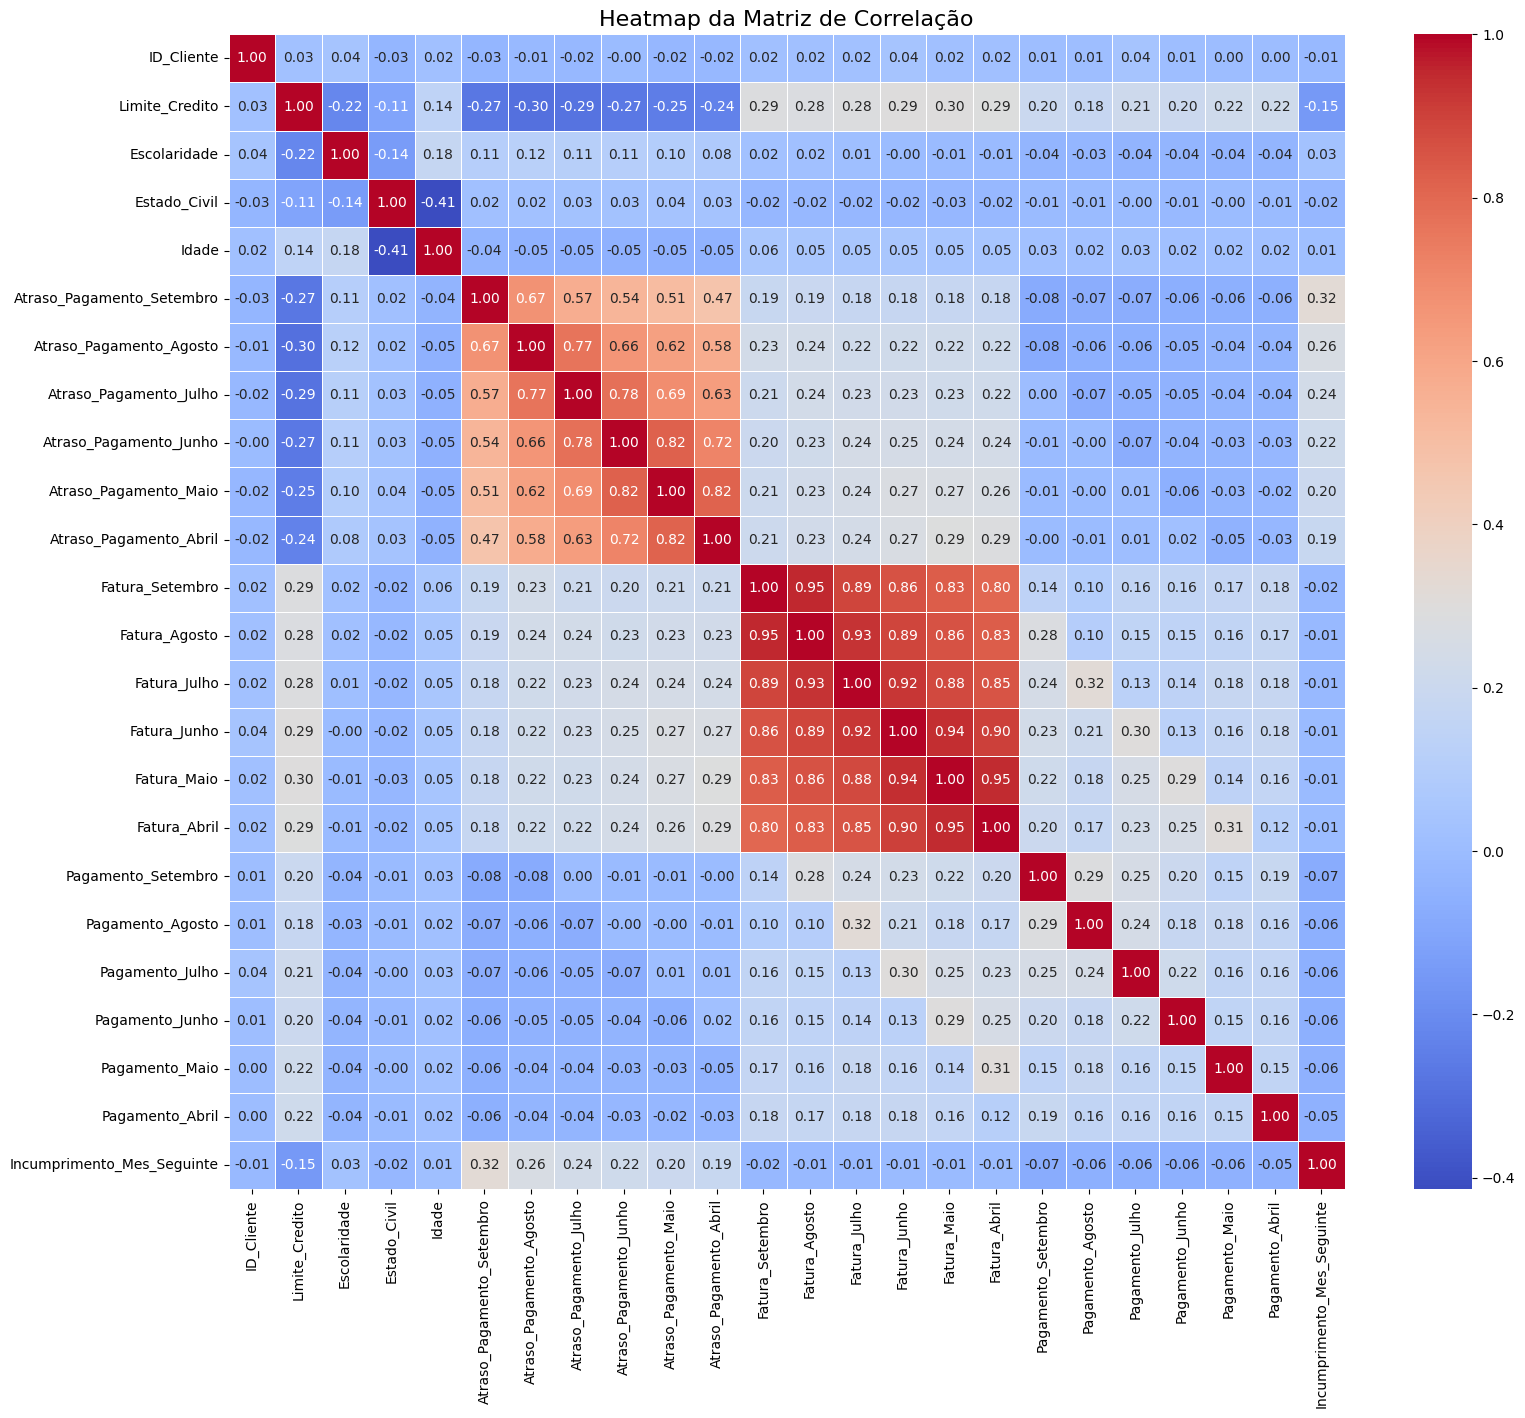

In [107]:
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap da Matriz de Correlação', fontsize=16)
plt.show()

### Matriz de Correlação - Spearman

In [108]:
#@title Selecione o método de correlação:
correlation_method = 'spearman'

# Calcular a matriz de correlação apenas para colunas numéricas com o método selecionado
correlation_matrix_selected = df.select_dtypes(include=np.number).corr(method=correlation_method)

display(correlation_matrix_selected.head())

,ID_Cliente,Limite_Credito,Escolaridade,Estado_Civil,Idade,Atraso_Pagamento_Setembro,Atraso_Pagamento_Agosto,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,Atraso_Pagamento_Maio,...,Fatura_Junho,Fatura_Maio,Fatura_Abril,Pagamento_Setembro,Pagamento_Agosto,Pagamento_Julho,Pagamento_Junho,Pagamento_Maio,Pagamento_Abril,Incumprimento_Mes_Seguinte
ID_Cliente,1.000000,0.030636,0.033318,-0.028316,0.024692,-0.025029,-0.004919,-0.009176,-0.004307,-0.015982,...,0.032995,0.015142,0.019961,0.011925,0.050900,0.093546,0.021932,0.012320,0.037875,-0.013952
Limite_Credito,0.030636,1.000000,-0.263575,-0.113535,0.186498,-0.296461,-0.342596,-0.331615,-0.308658,-0.284936,...,0.072894,0.080694,0.088094,0.272367,0.278401,0.284468,0.283411,0.293749,0.317459,-0.169586
Escolaridade,0.033318,-0.263575,1.000000,-0.162415,0.158742,0.132288,0.168715,0.162047,0.151878,0.136501,...,0.069018,0.060286,0.055977,-0.041727,-0.046651,-0.042048,-0.043324,-0.049463,-0.053060,0.044369
Estado_Civil,-0.028316,-0.113535,-0.162415,1.000000,-0.462842,0.023312,0.036950,0.041867,0.044805,0.046881,...,0.005736,0.003680,0.004795,-0.003407,-0.015065,-0.012432,-0.015854,-0.012817,-0.014808,-0.026490
Idade,0.024692,0.186498,0.158742,-0.462842,1.000000,-0.063752,-0.083272,-0.083193,-0.080192,-0.083152,...,-0.003337,-0.000349,0.000212,0.033570,0.044200,0.033358,0.040535,0.038136,0.038988,0.005135


A matriz de Correlação de Spearman, contrariamente à de Pearsosn, fornece uma visão mais robusta e flexível das associações entre variáveis. Esta matriz é especialemnte indicada para dados financeiros com distribuições assimétricas.<br>
A utilização destas duas matrizes permite-nos obter uma compreensão mais completa da estrutura dos dados e consequentemente melhorar as decisões de modelação dos dados.

Inciei o estudo com a matriz de corelação de Pearson, mas, tendo em conta que esta matriz explica uma correlação linear, utilizei a matriz de corelação de Spearman que utiliza uma correlação não linear. <br>
Veriquei assim que existe uma maior correlação entre as variáveis através deste último método. <br>
Por este motivo, o método mais adequado é o método de corelação de Spearman.

### Heatmap da Matriz de Correlação - Spearman

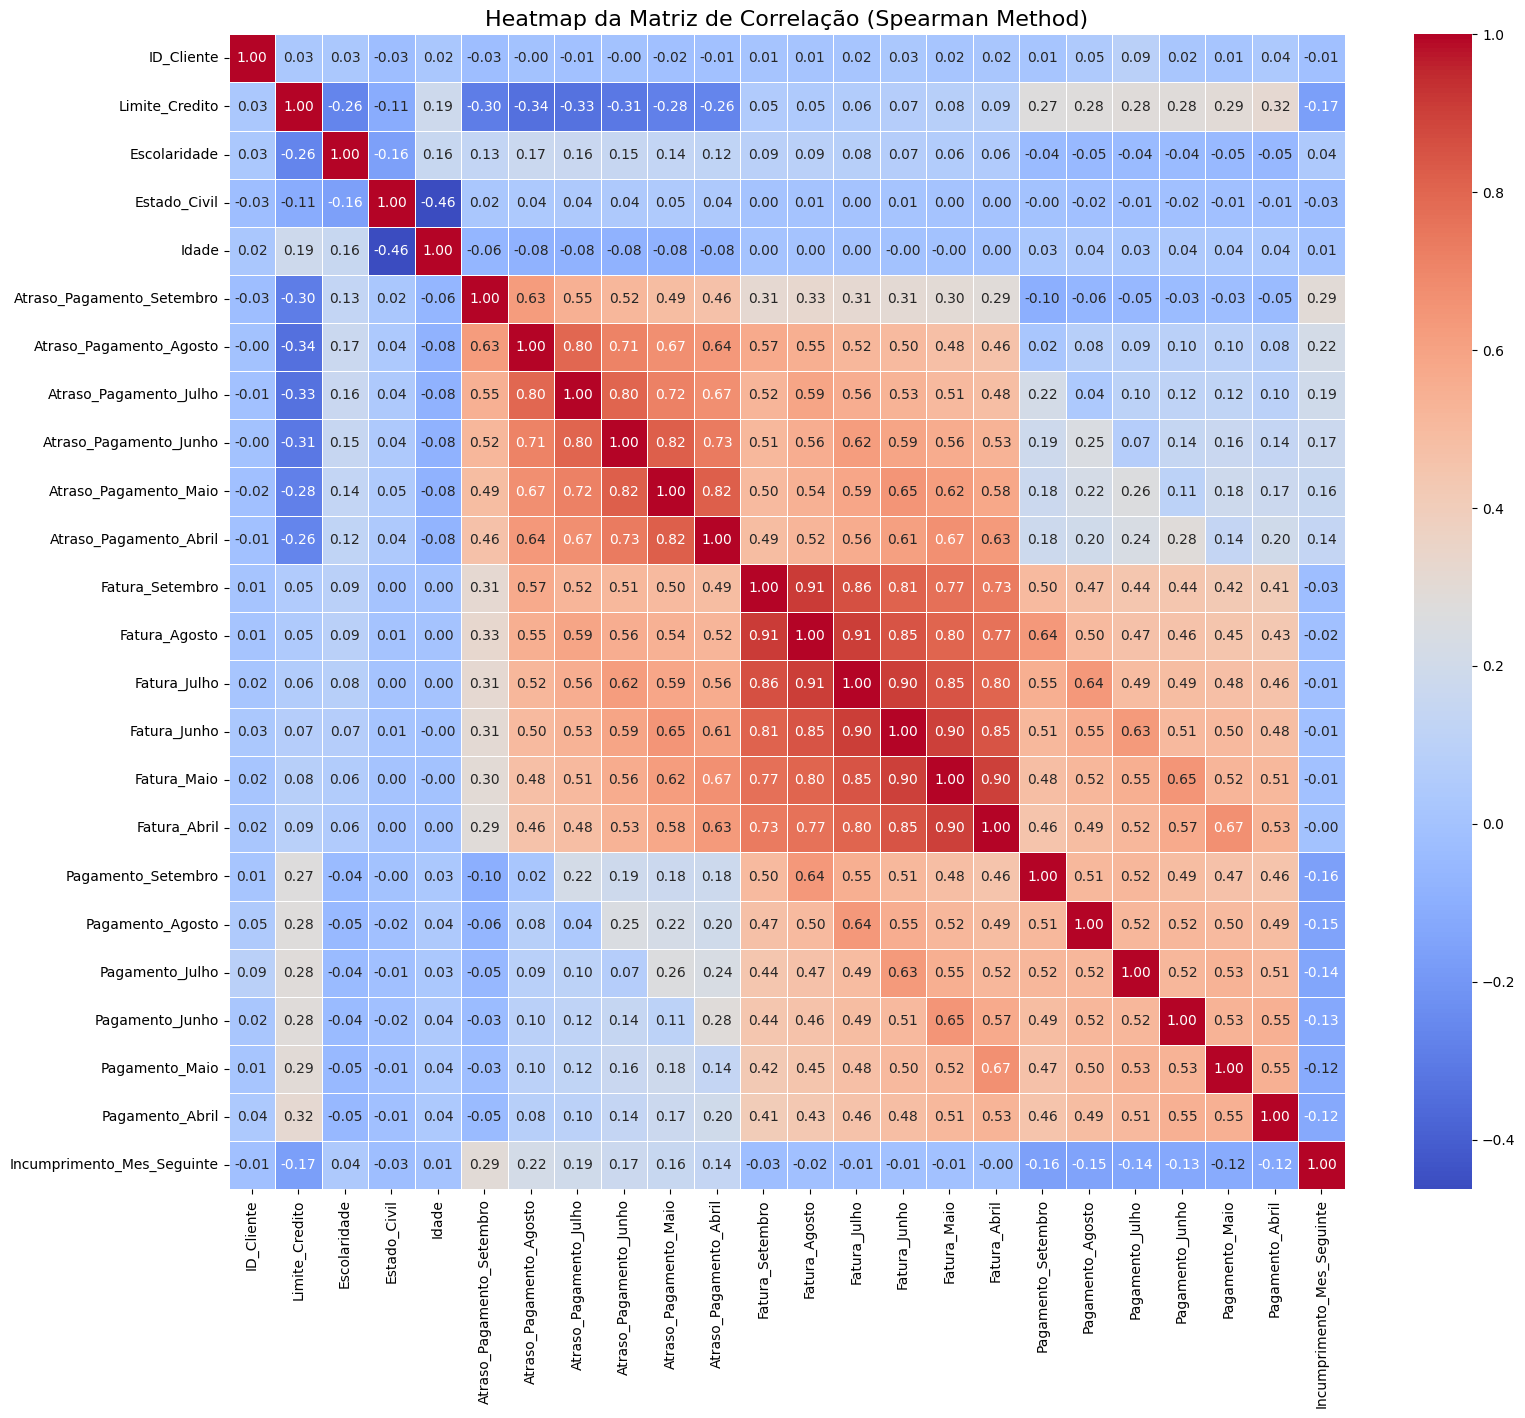

In [109]:
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Heatmap da Matriz de Correlação ({correlation_method.capitalize()} Method)', fontsize=16)
plt.show()

## II - Pré processamento dos dados

O pré-processamento dos dados corresponde ao conjunto de técnicas aplicadas aos dados brutos com o objetivo de os tornar adequados à análise estatística e à modelação em Machine Learning.<br>
<br>
Os dados reais, especialmente no contexto financeiro, contêm frequentemente valores em falta, escalas diferentes, variáveis categóricas, outliers e desbalanceamento de classes, o que pode comprometer o desempenho e a fiabilidade dos modelos se não for tratado adequadamente.<br>
O pré-processamento dos dados permite-nos melhorar a qualidade dos dados, evitar resultados incorretos, garantir que os modelos conseguem aprender padrões relevantes, e aumentar a estabilidadae dos modelos. <br>
O pré-processamento dos dados contempla:<br>
- Tratamento dos valores em falta<br>
- Codificação de variáveis<br>
- Remoção de variáveis irrelevantes<br>
- Balanceamento da variável alvo

### Divisão do Dataset em Treino e Teste

In [110]:
#Remover variável irrelevante 'ID_Cliente'
df = df.drop('ID_Cliente', axis=1)

# Separar as features (X) da variável alvo (y)
X = df.drop('Incumprimento_Mes_Seguinte', axis=1)
y = df['Incumprimento_Mes_Seguinte'] #variável target

# Dividir o dataset em conjuntos de treino e teste
# Usamos stratify=y para garantir que a proporção da variável alvo seja a mesma em treino e teste
# random_state para reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")
print(f"Tamanho do conjunto de treino (y_train): {y_train.shape}")
print(f"Tamanho do conjunto de teste (y_test): {y_test.shape}")

print(f"Proporção da variável alvo no treino:\n{y_train.value_counts(normalize=True)}")
print(f"Proporção da variável alvo no teste:\n{y_test.value_counts(normalize=True)}")

Tamanho do conjunto de treino (X_train): (21000, 23)
Tamanho do conjunto de teste (X_test): (9000, 23)
Tamanho do conjunto de treino (y_train): (21000,)
Tamanho do conjunto de teste (y_test): (9000,)
Proporção da variável alvo no treino:
Incumprimento_Mes_Seguinte
0    0.77881
1    0.22119
Name: proportion, dtype: float64
Proporção da variável alvo no teste:
Incumprimento_Mes_Seguinte
0    0.778778
1    0.221222
Name: proportion, dtype: float64


Inicialmente removi a variável irrelevante "ID_Cliente".<br>

Por forma a garantir a robustez do modelo dividi os dados em treino e teste. Em machine learning esta divisão é fundamentar, para garantir que o modelo treina com base num determinado conjunto de dados e posteriormente testa noutro conjunto de dados, sem que tenha tido conhecimento dos dados do treino. Caso contrário o modelo iria decorar os dados.<br>
O treino é utilizado para ajustar os prametros do modelo, e o teste para avaliar o desempenho do modelo em dados que nunca viu antes.<br>
<br>
Relativamente aos parâmetros utilizados, a divisão que irei fazer (test_size=0.3) significa que 30% dos dados serão utilizados para teste e 70% para treino.<br>
Quanto ao parãmetro random_state=42, este parâmetro controla a aleatoriedade da divisão. Serve para que o código possa ser reproduzido novamente gerando os mesmos resultados.
Já o stratify garante que a proporção das classes será mantida no treino e no teste.

Verifiquei que os dados estão desbalanceados. No treino temos na classe "0" 77,881% dos casos e 22,110% na classe "1". Já na classe de teste verificamos que a classe "0" tem 77,8778% dos casos e a classe "1" 22,1222%. <br> 
De seguida irei proceder à imputação dos valores em falta, e posteriormente ao balancaemnto do conjunto de treino com SMOTE, por forma a balancear os dados.

In [111]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [112]:
# Verificar valores ausentes antes da imputação
print("Valores ausentes em X_train antes da imputação:")
print(X_train[['Genero', 'Idade']].isnull().sum())

print("\nValores ausentes em X_test antes da imputação:")
print(X_test[['Genero', 'Idade']].isnull().sum())

# Calcular a moda da coluna 'Genero' no X_train
mode_genero_train = X_train['Genero'].mode()[0]
print(f"\nModa de 'Genero' (X_train): {mode_genero_train}")

# Calcular a mediana da coluna 'Idade' no X_train
median_idade_train = X_train['Idade'].median()
print(f"Mediana de 'Idade' (X_train): {median_idade_train}")

# Preencher valores ausentes na coluna 'Genero' em X_train e X_test
X_train['Genero'] = X_train['Genero'].fillna(mode_genero_train)
X_test['Genero'] = X_test['Genero'].fillna(mode_genero_train)

# Preencher valores ausentes na coluna 'Idade' em X_train e X_test
X_train['Idade'] = X_train['Idade'].fillna(median_idade_train)
X_test['Idade'] = X_test['Idade'].fillna(median_idade_train)

# Verificar valores ausentes após a imputação
print("\nValores ausentes em X_train após a imputação de Genero e Idade:")
print(X_train[['Genero', 'Idade']].isnull().sum())

print("\nValores ausentes em X_test após a imputação de Genero e Idade:")
print(X_test[['Genero', 'Idade']].isnull().sum())

Valores ausentes em X_train antes da imputação:
Genero    2
Idade     4
dtype: int64

Valores ausentes em X_test antes da imputação:
Genero    1
Idade     1
dtype: int64

Moda de 'Genero' (X_train): Feminino
Mediana de 'Idade' (X_train): 34.0

Valores ausentes em X_train após a imputação de Genero e Idade:
Genero    0
Idade     0
dtype: int64

Valores ausentes em X_test após a imputação de Genero e Idade:
Genero    0
Idade     0
dtype: int64


Conforme referido anteriormente as variáveis "Genero" e "Idade" possuiam 3 e 5 valores em falta, respetivamente.<br>
Na variável "Género" procedi à imputação dos valores em falta com base na moda, e na variável "Idade" com base na mediana.<br>
<br>
Acima verificamos que os valores em falta foram substituídos, tendo ficado ambas as variáveis sem valores ausentes.


In [113]:
X_train

,Limite_Credito,Genero,Escolaridade,Estado_Civil,Idade,Atraso_Pagamento_Setembro,Atraso_Pagamento_Agosto,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,Atraso_Pagamento_Maio,...,Fatura_Julho,Fatura_Junho,Fatura_Maio,Fatura_Abril,Pagamento_Setembro,Pagamento_Agosto,Pagamento_Julho,Pagamento_Junho,Pagamento_Maio,Pagamento_Abril
11018,160000,Feminino,2,2,32.0,0,0,0,0,0,...,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500
1710,100000,Feminino,1,2,30.0,0,0,0,0,2,...,42283,51539,50583,52588,5000,10000,10000,0,2846,1936
4618,80000,Masculino,1,2,29.0,0,0,0,0,0,...,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600
5482,20000,Feminino,2,1,27.0,0,0,-1,-1,-2,...,780,0,0,0,1006,780,0,0,0,0
26187,50000,Feminino,1,2,30.0,-2,-2,-2,-2,-2,...,0,0,0,0,2070,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,200000,Feminino,2,1,32.0,0,0,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
13921,120000,Feminino,2,2,24.0,0,0,0,0,0,...,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,120000,Feminino,1,2,24.0,0,0,0,0,0,...,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,360000,Masculino,1,1,57.0,1,-2,-1,-1,-1,...,860,246,-46,-46,0,860,246,0,0,0


In [114]:
X_train_processed = pd.get_dummies(X_train, columns=['Genero'], drop_first=False)
X_test_processed = pd.get_dummies(X_test, columns=['Genero'], drop_first=False)

# Align columns - crucial for consistent feature sets between train and test
common_cols = list(set(X_train_processed.columns) | set(X_test_processed.columns))

X_train_processed = X_train_processed.reindex(columns=common_cols, fill_value=0)
X_test_processed = X_test_processed.reindex(columns=common_cols, fill_value=0)

No código acima procedi à transformação da variável categórica "Género"em variável numérica binária.<br>
De seguida alinhei as colunas em treino e em teste (passo fundamental para que o modelo tenha em treino e em teste as mesmas colunas e a mesma ordem)<br>

In [115]:
X_train_processed.head()

,Pagamento_Abril,Atraso_Pagamento_Agosto,Fatura_Agosto,Atraso_Pagamento_Setembro,Limite_Credito,Fatura_Julho,Pagamento_Julho,Idade,Escolaridade,Atraso_Pagamento_Maio,...,Atraso_Pagamento_Julho,Atraso_Pagamento_Junho,Atraso_Pagamento_Abril,Estado_Civil,Pagamento_Junho,Genero_Masculino,Pagamento_Setembro,Genero_Feminino,Fatura_Setembro,Fatura_Abril
11018,5500,0,156259,0,160000,155404,5600,32.0,2,0,...,0,0,0,2,6000,False,6000,True,156098,155818
1710,1936,0,32903,0,100000,42283,10000,30.0,1,2,...,0,0,0,2,0,False,5000,True,28383,52588
4618,1600,0,75323,0,80000,64277,1556,29.0,1,0,...,0,0,0,2,1600,True,3300,False,73722,42804
5482,0,0,2160,0,20000,780,0,27.0,2,-2,...,-1,-1,-2,1,0,False,1006,True,7286,0
26187,0,-2,2070,-2,50000,0,0,30.0,1,-2,...,-2,-2,-2,2,0,False,2070,True,0,0


### Balanceamento do Conjunto de Treino com SMOTE

In [116]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Distribuição original da classe no treino: {Counter(y_train)}")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print(f"Distribuição da classe no treino após SMOTE: {Counter(y_train_res)}")

Distribuição original da classe no treino: Counter({0: 16355, 1: 4645})
Distribuição da classe no treino após SMOTE: Counter({0: 16355, 1: 16355})


Após a aplicação do SMOTE (oversampling, onde são criados dados sintéticos e intercalados com os dados originais) verificamos que o número de observações da classe "0" e da classe "1" passou a ser igual, 16355, encontrando-se balanceada.

## III - Modelagem

De seguida irei apresentar a matriz de confusão, que me permitirá obter os falsos positivos e falsos negativos. <br>
A matriz de confusão caracteríza-se por mostrar detalhadamente os acertos e erros do modelo.

O banco tem um custo de falsos negativos (FN) = 1000€ e de falsos positivos (FP) = 150€. <br>

Irei utilizar o modelo de Regressão Logísctica, que se caracteriza por ser uma técnica estatística para prever a probabilidade de uma variável dependente categórica (como Sim/Não) com base em uma ou mais variáveis independentes, usando a função logística (sigmoide) para mapear a saída para um valor entre 0 e 1.<br>
Posteriormente utilizarei o modelo Random Forest, baseado em multiplas árvores de decisão, cada uma delas treinada com uma amostra aleatória dos dados e com um subconjunto aleatório de variáveis. A previsão final é feita por classificação (votação das árvores) ou regressão (média das previsões).<br>
A métrica que pretendo maximizar é a redução de falsos negativos ("Recall"), com vista à obtençao do custo mais baixo para o banco. <br>

--- Regressão Logística ---
Matriz de Confusão:
[[3824 3185]
 [ 616 1375]]

Recall: 0.6906
Precision: 0.3015
Accuracy: 0.5777
F1-Score: 0.4198


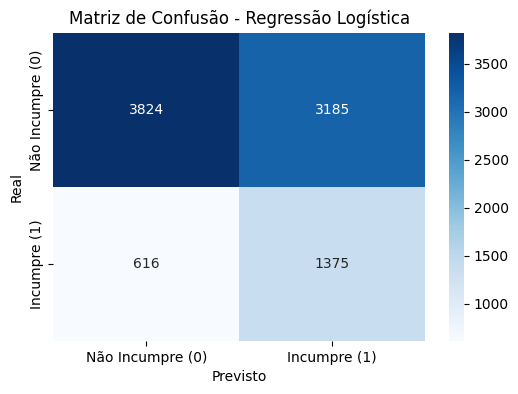

In [117]:
# Importar LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

# Inicializar e treinar o modelo de Regressão Logística
# random_state para reprodutibilidade
logistic_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
logistic_model.fit(X_train_res, y_train_res)

# Fazer previsões no conjunto de teste
y_pred_logistic = logistic_model.predict(X_test_processed)

# Avaliar o desempenho do modelo
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

print("--- Regressão Logística ---")
print("Matriz de Confusão:")
print(conf_matrix_logistic)
print(f"\nRecall: {recall_logistic:.4f}")
print(f"Precision: {precision_logistic:.4f}")
print(f"Accuracy: {accuracy_logistic:.4f}")
print(f"F1-Score: {f1_logistic:.4f}")

# Para uma melhor visualização da matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Incumpre (0)', 'Incumpre (1)'],
            yticklabels=['Não Incumpre (0)', 'Incumpre (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

In [118]:
FalsosNegativos = 1000 * 563
FalsosPositivos = 150 * 3457
TotalCusto = FalsosNegativos + FalsosPositivos
print(TotalCusto)

1081550


--- Random Forest ---
Matriz de Confusão:
[[6303  706]
 [1094  897]]

Recall: 0.4505
Precision: 0.5596
Accuracy: 0.8000
F1-Score: 0.4992


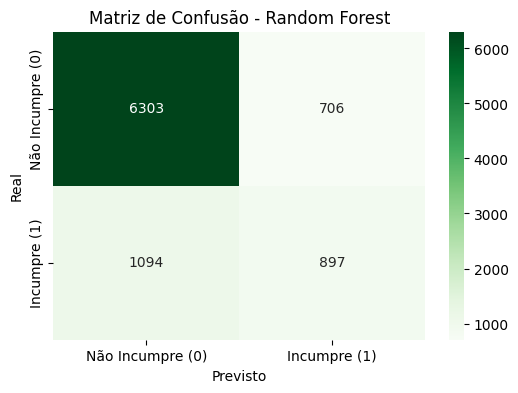

In [119]:
# Importar RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

# Inicializar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)

# Fazer previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test_processed)

# Avaliar o desempenho do modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("--- Random Forest ---")
print("Matriz de Confusão:")
print(conf_matrix_rf)
print(f"\nRecall: {recall_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

# Para uma visualização gráfica da matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Não Incumpre (0)', 'Incumpre (1)'],
            yticklabels=['Não Incumpre (0)', 'Incumpre (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

In [120]:
FalsosNegativos = 1000 * 1080
FalsosPositivos = 150 * 713
TotalCusto = FalsosNegativos + FalsosPositivos
print(TotalCusto)

1186950


In [121]:
FN_rf = conf_matrix_rf[1, 0] # Real 1, Predicted 0
FP_rf = conf_matrix_rf[0, 1] # Real 0, Predicted 1

Custo_FN_rf = FN_rf * 1000
Custo_FP_rf = FP_rf * 150

TotalCusto_rf = Custo_FN_rf + Custo_FP_rf

print(f"Custo de Falsos Negativos (Random Forest): {Custo_FN_rf}€")
print(f"Custo de Falsos Positivos (Random Forest): {Custo_FP_rf}€")
print(f"Custo Total (Random Forest): {TotalCusto_rf}€")

print("\n--- Comparação de Custos ---")
print(f"Custo Total (Regressão Logística): {TotalCusto}€")
print(f"Custo Total (Random Forest): {TotalCusto_rf}€")

if TotalCusto_rf < TotalCusto:
    print("O modelo Random Forest tem um custo total menor.")
elif TotalCusto_rf > TotalCusto:
    print("O modelo de Regressão Logística tem um custo total menor.")
else:
    print("Ambos os modelos têm o mesmo custo total.")

Custo de Falsos Negativos (Random Forest): 1094000€
Custo de Falsos Positivos (Random Forest): 105900€
Custo Total (Random Forest): 1199900€

--- Comparação de Custos ---
Custo Total (Regressão Logística): 1186950€
Custo Total (Random Forest): 1199900€
O modelo de Regressão Logística tem um custo total menor.


Após testar os dois modelos, LogisticRegression e RandomForest, verifico que o modelo LogisticRegression tem um custo total menor para o Banco.

In [144]:
from sklearn.metrics import confusion_matrix

def calcular_custo(cm, custo_fp=150, custo_fn=1000):
    tn, fp, fn, tp = cm.ravel()
    return fp * custo_fp + fn * custo_fn

thresholds = [0.4, 0.6]
resultados = []

for t in thresholds:
    y_pred= (y_probs >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    custo = calcular_custo(cm)
    print(f"Threshold {t}")
    print("Matriz de Confusão:")
    print(cm)
    print(f"Custo total: {custo}\n")
    resultados.append((t, custo))

threshold_otimo, custo_minimo = min(resultados, key=lambda x: x[1])
print(f"Threshold ótimo: {threshold_otimo} com custo {custo_minimo}")


Threshold 0.4
Matriz de Confusão:
[[5773 1236]
 [ 875 1116]]
Custo total: 1060400

Threshold 0.6
Matriz de Confusão:
[[6572  437]
 [1303  688]]
Custo total: 1368550

Threshold ótimo: 0.4 com custo 1060400


Reduzir o threshold para 0.4 representa uma melhoria significativa para o banco, pois permite-nos reduzir o custo total de 1186950€ para 1060400€, ou seja, uma redução de 126550€ apenas com o ajuste do threshold.

HUGO PIRES <br>
Dezembro de 2025 